## Import Library

In [179]:
# Import basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Import library for load env & connect database
import supabase
import os
from dotenv import load_dotenv
import psycopg2
from psycopg2 import sql

# Import library for modelling & tree rule-based logic
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, _tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Import Data

### Define Read Function

In [180]:
# Load ENV
load_dotenv()

# Create function to read table from given ENV
def read_all(table_name: str, schema: str = "public") -> pd.DataFrame:
    conn = psycopg2.connect(
        host=os.getenv("host"),
        port=os.getenv("port"),
        dbname=os.getenv("database"),
        user=os.getenv("user"),
        password=os.getenv("password"),
        sslmode="require",
        connect_timeout=30,
    )
    try:
        with conn.cursor() as cur:
            q = sql.SQL("SELECT * FROM {}.{}").format(
                sql.Identifier(schema),
                sql.Identifier(table_name)
            )
            cur.execute(q)
            rows = cur.fetchall()
            cols = [d[0] for d in cur.description]
        return pd.DataFrame(rows, columns=cols)
    finally:
        conn.close()

### Employees

In [181]:
# Read Data Employees
df_employees = read_all("employees")
df_employees.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


### Performance Yearly

In [182]:
# Read Data Performance
df_performance = read_all("performance_yearly")
df_performance.head()

,employee_id,rating,year
0,EMP100000,2.0,2021
1,EMP100001,None,2021
2,EMP100002,2.0,2021
3,EMP100003,None,2021
4,EMP100004,3.0,2021


### Competencies Yearly

In [183]:
# Read Data Competencies
df_competencies = read_all("competencies_yearly")
df_competencies.head()

,employee_id,score,pillar_code,year
0,EMP100000,2.0,GDR,2021
1,EMP100001,None,GDR,2021
2,EMP100002,1.0,GDR,2021
3,EMP100003,None,GDR,2021
4,EMP100004,3.0,GDR,2021


### PAPI Scores

In [184]:
# Read Data PAPI Scores
df_papi_scores = read_all("papi_scores")
df_papi_scores.head()

,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0
2,EMP100002,Papi_N,9.0
3,EMP100003,Papi_N,9.0
4,EMP100004,Papi_N,7.0


### Profiles Psych

In [185]:
# Read Data Psychometric Profiles
df_psych = read_all("profiles_psych")
df_psych.head()

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2
1,EMP100001,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3
2,EMP100002,66,38,DC,Dominant-Conscientious,None,109.0,20.0,3
3,EMP100003,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3
4,EMP100004,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9


### Strengths

In [186]:
# Read Data Strengths
df_strengths = read_all("strengths")
df_strengths.head()

,employee_id,rank,theme
0,EMP100000,1,
1,EMP100001,1,Responsibility
2,EMP100002,1,Restorative
3,EMP100003,1,Belief
4,EMP100004,1,Deliberative


### Table Dimension

In [187]:
# Read all table Dimensions
table_dims = ['dim_areas', 'dim_companies', 'dim_competency_pillars', 'dim_departments',
              'dim_directorates', 'dim_divisions', 'dim_education', 'dim_grades', 'dim_majors',
              'dim_positions']

dfs = {}

for table in table_dims:
    df = read_all(table)                 # SELECT * FROM public.<table>
    var_name = f"df_{table}"             # contoh: df_dim_areas
    globals()[var_name] = df             # buat variable dinamis
    dfs[table] = df                      # simpan juga ke dict
    print(f"Loaded {table}: {len(df)} rows -> variable `{var_name}`")

Loaded dim_areas: 4 rows -> variable `df_dim_areas`
Loaded dim_companies: 4 rows -> variable `df_dim_companies`
Loaded dim_competency_pillars: 10 rows -> variable `df_dim_competency_pillars`
Loaded dim_departments: 6 rows -> variable `df_dim_departments`
Loaded dim_directorates: 3 rows -> variable `df_dim_directorates`
Loaded dim_divisions: 5 rows -> variable `df_dim_divisions`
Loaded dim_education: 4 rows -> variable `df_dim_education`
Loaded dim_grades: 3 rows -> variable `df_dim_grades`
Loaded dim_majors: 6 rows -> variable `df_dim_majors`
Loaded dim_positions: 6 rows -> variable `df_dim_positions`


## Data Preprocessing

### Flagging Rating

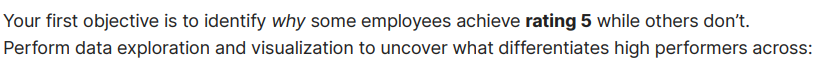

In [188]:
# Flagging rating : rating = 5 --> True else False 
df_performance['flag'] = df_performance['rating'].eq(5.0)
# Replace value : True --> Achieved ; False --> Not Achieved
df_performance['flag'] = df_performance['flag'].replace({True: 'Achieved',
                                                         False: 'Not Achieved'})
df_performance.head()

,employee_id,rating,year,flag
0,EMP100000,2.0,2021,Not Achieved
1,EMP100001,None,2021,Not Achieved
2,EMP100002,2.0,2021,Not Achieved
3,EMP100003,None,2021,Not Achieved
4,EMP100004,3.0,2021,Not Achieved


### Data Merging

In [189]:
# Create function to get dimension columns
def infer_dim_cols(dim_df: pd.DataFrame, prefix: str):
    cols = list(dim_df.columns)

    # Find _id in column names as table dimensions
    id_candidates = [f"{prefix}_id", "id"] + [c for c in cols if c.endswith("_id")]
    id_col = next((c for c in id_candidates if c in cols), None)
    if id_col is None:
        raise ValueError(f"Tidak ketemu kolom id pada dim {prefix}: {cols}")

    # Match with dim to get _name
    name_candidates = [f"{prefix}_name", "name", f"{prefix}", f"{prefix}_desc"] + \
                      [c for c in cols if "name" in c.lower() or "desc" in c.lower()]
    name_col = next((c for c in name_candidates if c in cols and c != id_col), None)
    if name_col is None:
        # fallback: get first columns as _id
        name_col = next((c for c in cols if c != id_col), None)

    return id_col, name_col

# Mapping dimensions
dims = [
    ("company",     "company_id",     dfs["dim_companies"]),
    ("area",        "area_id",        dfs["dim_areas"]),
    ("position",    "position_id",    dfs["dim_positions"]),
    ("department",  "department_id",  dfs["dim_departments"]),
    ("division",    "division_id",    dfs["dim_divisions"]),
    ("directorate", "directorate_id", dfs["dim_directorates"]),
    ("grade",       "grade_id",       dfs["dim_grades"]),
    ("education",   "education_id",   dfs["dim_education"]),
    ("major",       "major_id",       dfs["dim_majors"]),
]

# Left Join between Employees & Table Dimensions
df_employees_dimension = df_employees.copy()

# For Loop for Each Dimension
for prefix, fk_col, dim_df in dims:
    dim_id_col, dim_name_col = infer_dim_cols(dim_df, prefix)
    join_cols = [dim_id_col, dim_name_col]

    # Merge Dataset
    df_employees_dimension = df_employees_dimension.merge(
        dim_df[join_cols],
        how="left",
        left_on=fk_col,
        right_on=dim_id_col,
    )

    # Drop columns _id (FK in employees & _id in dim), then rename name columns to <prefix>_name
    df_employees_dimension.drop(columns=[fk_col, dim_id_col], inplace=True)
    # Name formatting
    new_name = f"{prefix}_name"
    if dim_name_col != new_name:
        df_employees_dimension.rename(columns={dim_name_col: new_name}, inplace=True)

df_employees_dimension.head()


,employee_id,fullname,nip,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name
0,EMP100000,Rendra Pratama,806137,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business
1,EMP100001,Wulan Setiawan,476388,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design
2,EMP100002,Julia Jatmiko Situmorang,941921,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business
3,EMP100003,Oka Halim,751615,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology
4,EMP100004,Dwi Pratama,443809,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology


### Filter Newest Data

In [190]:
# Create function to Get Latest Data from Employee
def latest_per_employee(df: pd.DataFrame) -> pd.DataFrame:
    # Make sure 'year' is numeric
    df2 = df.copy()
    df2['year'] = pd.to_numeric(df2['year'], errors='coerce')

    # Get latest data by latest year
    latest = (
        df2.sort_values(['employee_id', 'year'])   # urutkan naik
           .drop_duplicates('employee_id', keep='last')  # simpan baris terakhir tiap employee
           .reset_index(drop=True)
    )
    return latest

df_performance_latest = latest_per_employee(df_performance)
df_competencies_latest = latest_per_employee(df_competencies)

## Exploration & Visualization

### Competencies Pillars

#### Data Merge

In [191]:
# Merge Competencies Pillars with Performance
df_competencies_performance = df_performance_latest.merge(
    df_competencies, 
    how='left',
    on=['employee_id', 'year'],
    suffixes=('_performance', '_competencies')
).merge(
    dfs["dim_competency_pillars"],
    how='left',
    on='pillar_code'
)

# NULL handling
df_competencies_performance = df_competencies_performance.fillna(0)

df_competencies_performance.head()

,employee_id,rating,year,flag,score,pillar_code,pillar_label
0,DUP1942,5.0,2025,Achieved,5.0,GDR,Growth Drive & Resilience
1,DUP1942,5.0,2025,Achieved,4.0,CEX,Curiosity & Experimentation
2,DUP1942,5.0,2025,Achieved,5.0,IDS,Insight & Decision Sharpness
3,DUP1942,5.0,2025,Achieved,5.0,QDD,Quality Delivery Discipline
4,DUP1942,5.0,2025,Achieved,5.0,STO,Synergy & Team Orientation


#### Competencies Score Effect Against Performance

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\2716110104.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_bar, x='flag', y='score', ax=ax2, ci=None)


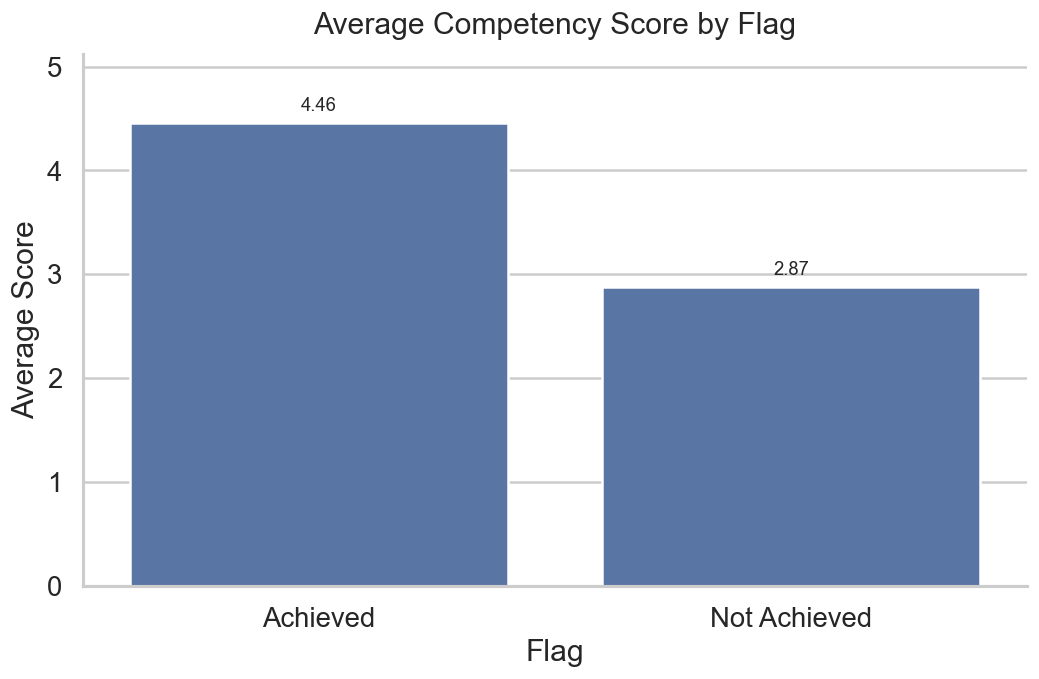

In [192]:
# Create function to plot average competency score against performance
def plot_competencies_performance(df: pd.DataFrame, show_labels: bool = True):
    """
    df : DataFrame with columns ['score', 'rating', 'flag']
    show_labels : tampilkan data label pada bar chart
    """
    sns.set_theme(style="whitegrid", context="talk")

    # Bar chart : mean score per flag
    df_bar = (
        df[['flag','score']]
        .dropna(subset=['score'])
        .groupby('flag', dropna=False, as_index=False)['score'].mean()
        .sort_values('score', ascending=False)
    )

    # Plot customize & styling
    fig2, ax2 = plt.subplots(figsize=(9, 6), dpi=120)
    sns.barplot(data=df_bar, x='flag', y='score', ax=ax2, ci=None)
    ax2.set_title("Average Competency Score by Flag", pad=12)
    ax2.set_xlabel("Flag")
    ax2.set_ylabel("Average Score")
    ax2.spines[['top','right']].set_visible(False)
    ax2.set_ylim(0, max(df_bar['score']) * 1.15)  # headroom untuk label
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)

    # Show data labels
    if show_labels:
        for p in ax2.patches:
            height = p.get_height()
            ax2.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=11, xytext=(0, 5),
                         textcoords='offset points')

    # Show plot
    plt.tight_layout()
    plt.show()

# Call function
plot_competencies_performance(df_competencies_performance, show_labels=True)

#### Pillar Competency Success Rate

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\3712150084.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rate, y='pillar_label', x='success_rate', ci=None, ax=ax)


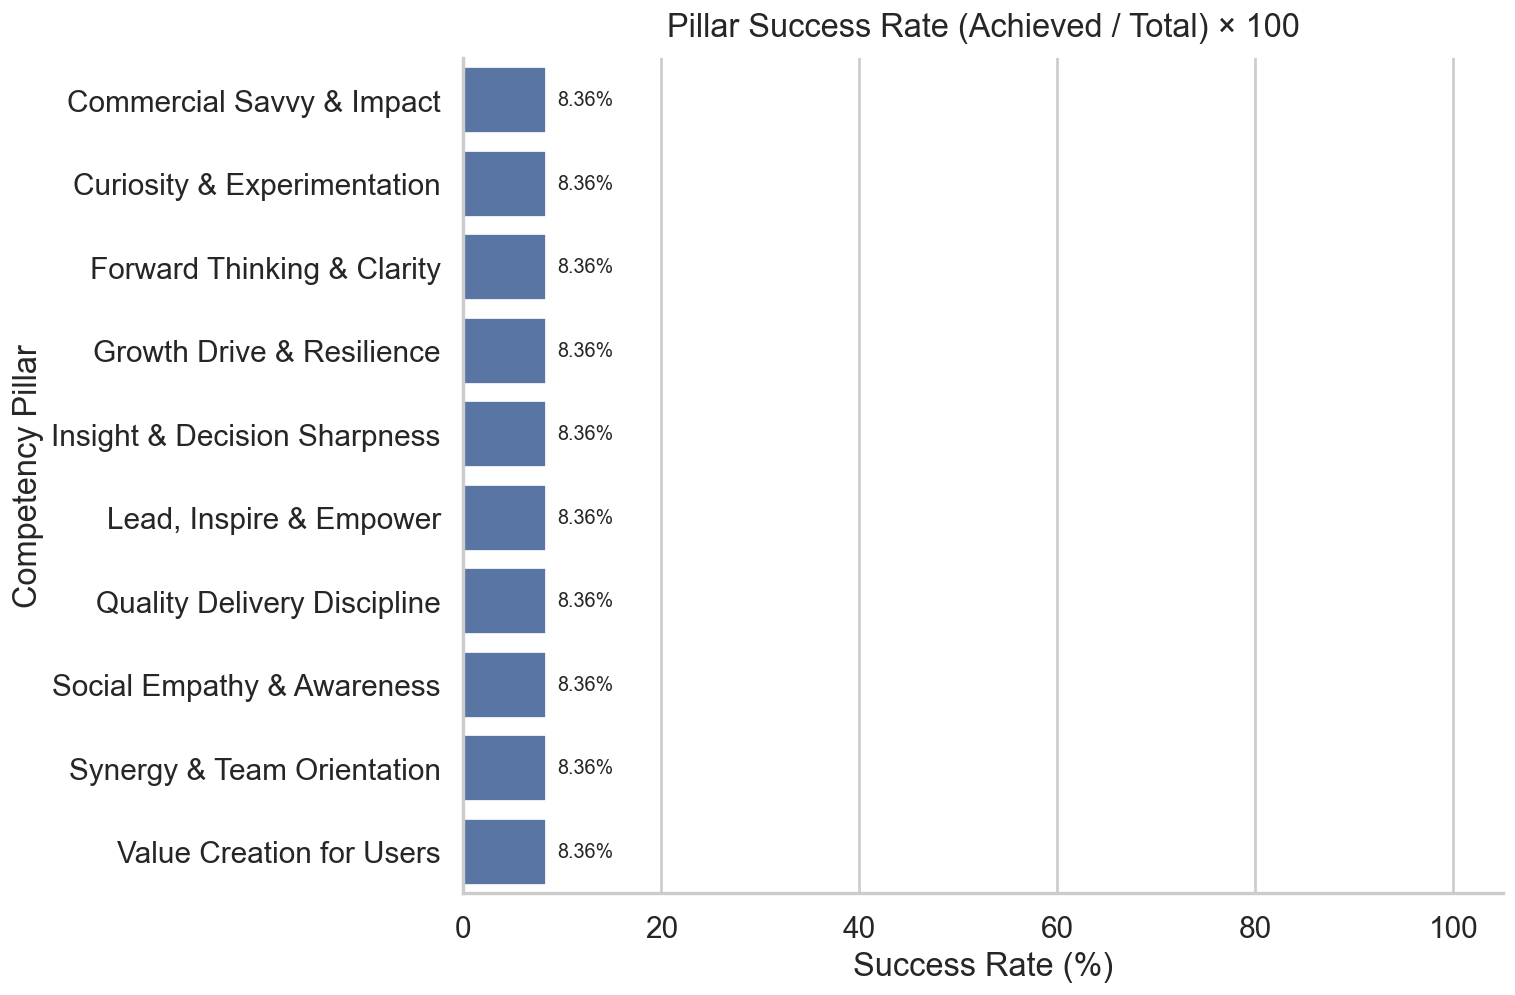

In [193]:
# Prepare data success rate per pillar_label
df_p = df_competencies_performance.copy()

# Handling empty data / None
df_p['pillar_label'] = df_p['pillar_label'].astype(str).str.strip()
df_p = df_p[df_p['pillar_label'].notna() & (df_p['pillar_label'] != '') & (df_p['pillar_label'].str.lower() != 'none')]

# Handling flag consistency 
df_p['flag'] = df_p['flag'].astype(str).str.strip().str.title()
df_p['is_achieved'] = df_p['flag'].eq('Achieved')

# Calculate Success Rate = Achieved / (Achieved + Not Achieved) * 100
rate = (
    df_p.groupby('pillar_label', as_index=False)
        .agg(achieved=('is_achieved', 'sum'), total=('is_achieved', 'size'))
)
rate['success_rate'] = (rate['achieved'] / rate['total'] * 100).round(2)
rate = rate.sort_values('success_rate', ascending=False)

# Plot Customization & Styling
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.barplot(data=rate, y='pillar_label', x='success_rate', ci=None, ax=ax)

ax.set_title("Pillar Success Rate (Achieved / Total) × 100", pad=12)
ax.set_xlabel("Success Rate (%)")
ax.set_ylabel("Competency Pillar")
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0, 105)  # 0–100 + headroom

# Show label data
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{w:.2f}%",
                (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()

### Psychometric Profiles

#### Data Merge

In [194]:
# Merge Psychometric Profiles with Performance
df_psych_performance = df_psych.merge(
    df_performance_latest, 
    how='left',
    on='employee_id').merge(
        df_papi_scores,
        how='left',
        on='employee_id'
    )

df_psych_performance.head()

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,year,flag,scale_code,score
0,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025,Not Achieved,Papi_N,2.0
1,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025,Not Achieved,Papi_G,5.0
2,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025,Not Achieved,Papi_A,1.0
3,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025,Not Achieved,Papi_L,7.0
4,EMP100000,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025,Not Achieved,Papi_P,3.0


#### Heatmap Correlation

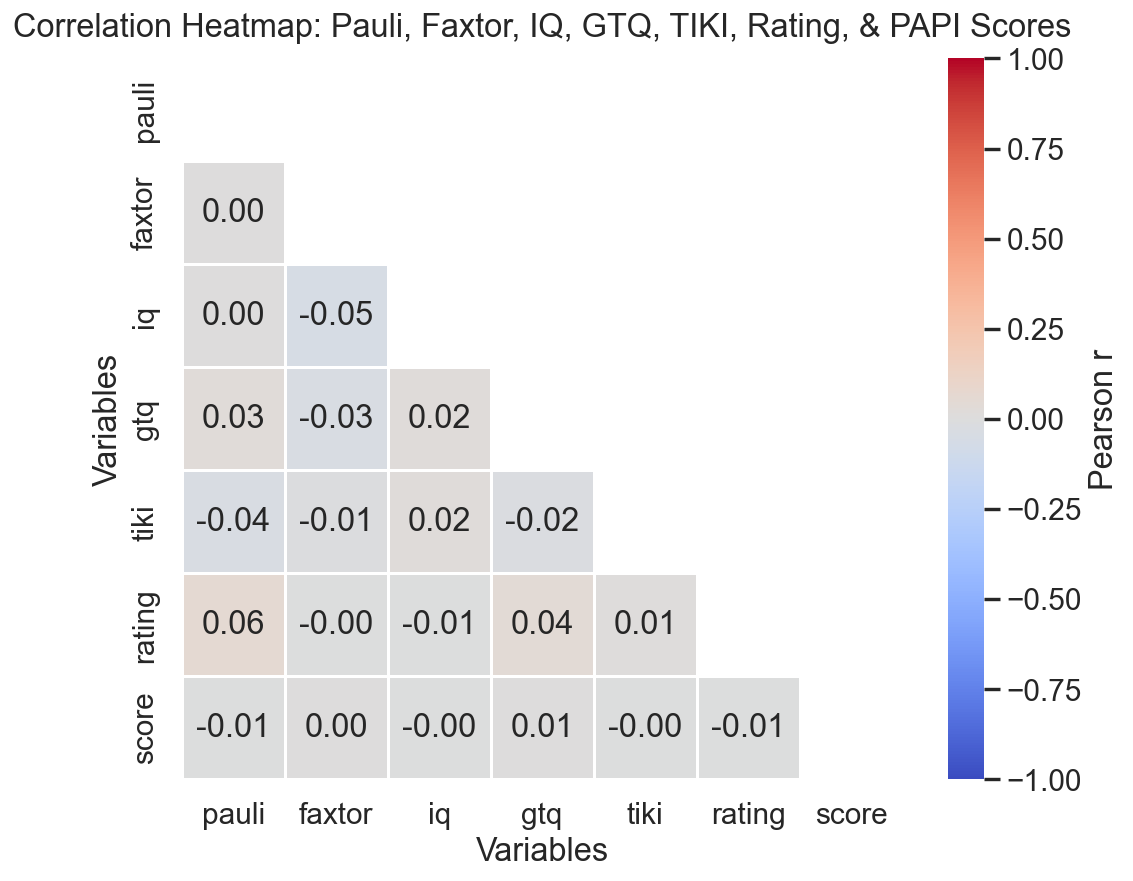

In [195]:
# Create function to plot heatmap correlation between psychometric profiles
def plot_psych_correlation(df: pd.DataFrame, show_labels: bool = True):
    # Define metrics psychometry
    cols = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki', 'rating', 'score']
    data = df[cols].apply(pd.to_numeric, errors='coerce')

    # Calculate correlation (Pearson)
    corr = data.corr(method='pearson')

    # Set theme plot
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(8.5, 7), dpi=130)

    # Only show lower triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Create a heatmap
    sns.heatmap(
        corr, mask=mask,
        annot=show_labels, fmt=".2f",
        cmap="coolwarm", vmin=-1, vmax=1, center=0,
        linewidths=.6, linecolor="white",
        cbar_kws={"label": "Pearson r"},
        square=True, ax=ax
    )

    # Plot customization & styling
    ax.set_title("Correlation Heatmap: Pauli, Faxtor, IQ, GTQ, TIKI, Rating, & PAPI Scores", pad=12)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Variables")
    ax.spines[['top','right','left','bottom']].set_visible(False)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call function
plot_psych_correlation(df_psych_performance, show_labels=True)

#### IQ Analysis of Performance

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\2142764081.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_bar, x='flag', y='iq', ci=None, ax=ax)


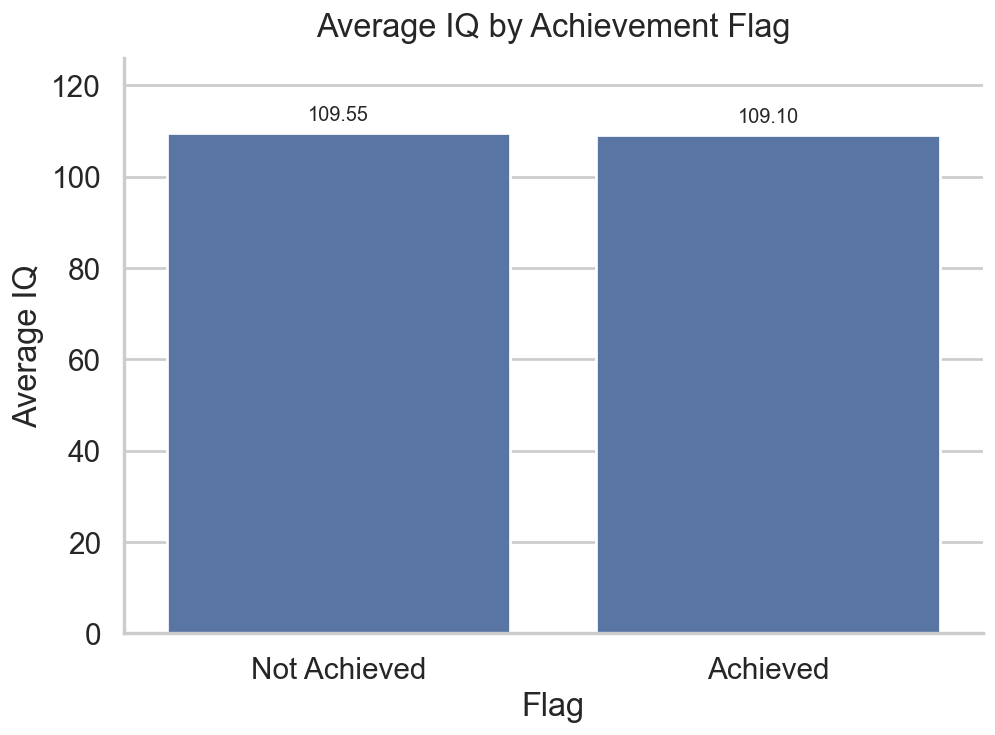

In [196]:
# Prepare data average IQ per flag (Achieved vs Not Achieved) ---
df_bar = (
    df_psych_performance
        .dropna(subset=['iq'])                       
        .groupby('flag', as_index=False)['iq']
        .mean()
        .sort_values('iq', ascending=False)          
)

# Plot barchart
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6), dpi=130)

sns.barplot(data=df_bar, x='flag', y='iq', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("Average IQ by Achievement Flag", pad=12)
ax.set_xlabel("Flag")
ax.set_ylabel("Average IQ")
ax.spines[['top','right']].set_visible(False)

# Show data labels
if not df_bar.empty:
    ax.set_ylim(0, df_bar['iq'].max() * 1.15)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=11,
                xytext=(0, 5), textcoords='offset points')

# Show plot
plt.tight_layout()
plt.show()


#### Top Performance MBTI

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\2192091244.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rate, y='mbti', x='success_rate', ci=None, ax=ax)


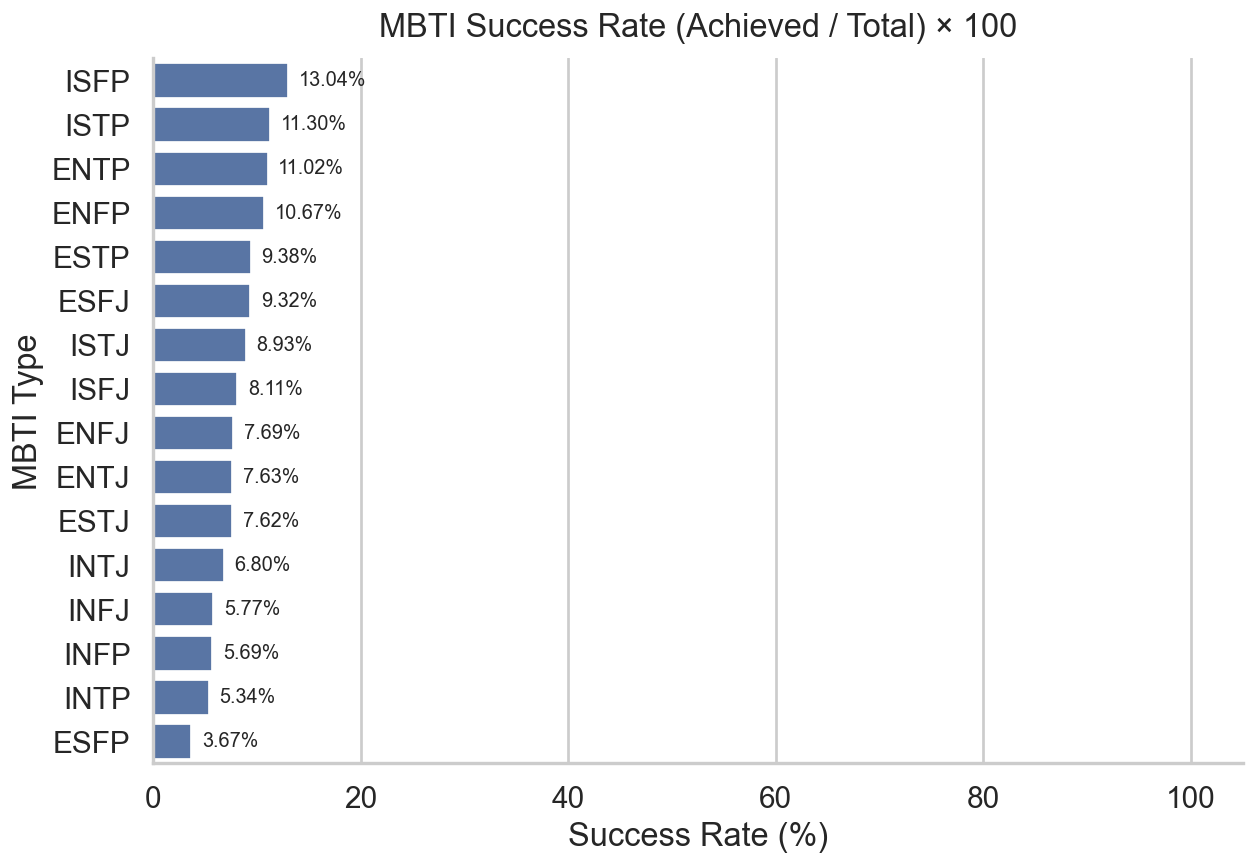

In [197]:
# Prepare data success rate per MBTI
df_mbti = df_psych_performance.copy()

# Set MBTI to UPPERCASE & handling None/empty
df_mbti['mbti'] = df_mbti['mbti'].astype(str).str.strip().str.upper()
df_mbti = df_mbti[~df_mbti['mbti'].isin(['', 'NONE', 'INFTJ'])]

# Flag consistency
df_mbti['flag'] = df_mbti['flag'].astype(str).str.strip().str.title()

# Define Achieved
df_mbti['is_achieved'] = df_mbti['flag'].eq('Achieved')

# Calculate success rate per MBTI (Achieved / Total) * 100
rate = (
    df_mbti.groupby('mbti', as_index=False)
           .agg(achieved=('is_achieved', 'sum'),
                total=('is_achieved', 'size'))
)
rate['success_rate'] = (rate['achieved'] / rate['total'] * 100).round(2)
rate = rate.sort_values('success_rate', ascending=False)

# Plot barchart horizontal
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(10, 7), dpi=130)

sns.barplot(data=rate, y='mbti', x='success_rate', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("MBTI Success Rate (Achieved / Total) × 100", pad=12)
ax.set_xlabel("Success Rate (%)")
ax.set_ylabel("MBTI Type")
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0, 105)  # 0–100 + headroom untuk label

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{w:.2f}%",
                (w, y), xytext=(6, 0), textcoords='offset points',
                va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()

#### Top Performance DISC

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\319764309.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rate, y='disc', x='success_rate', ci=None, ax=ax)


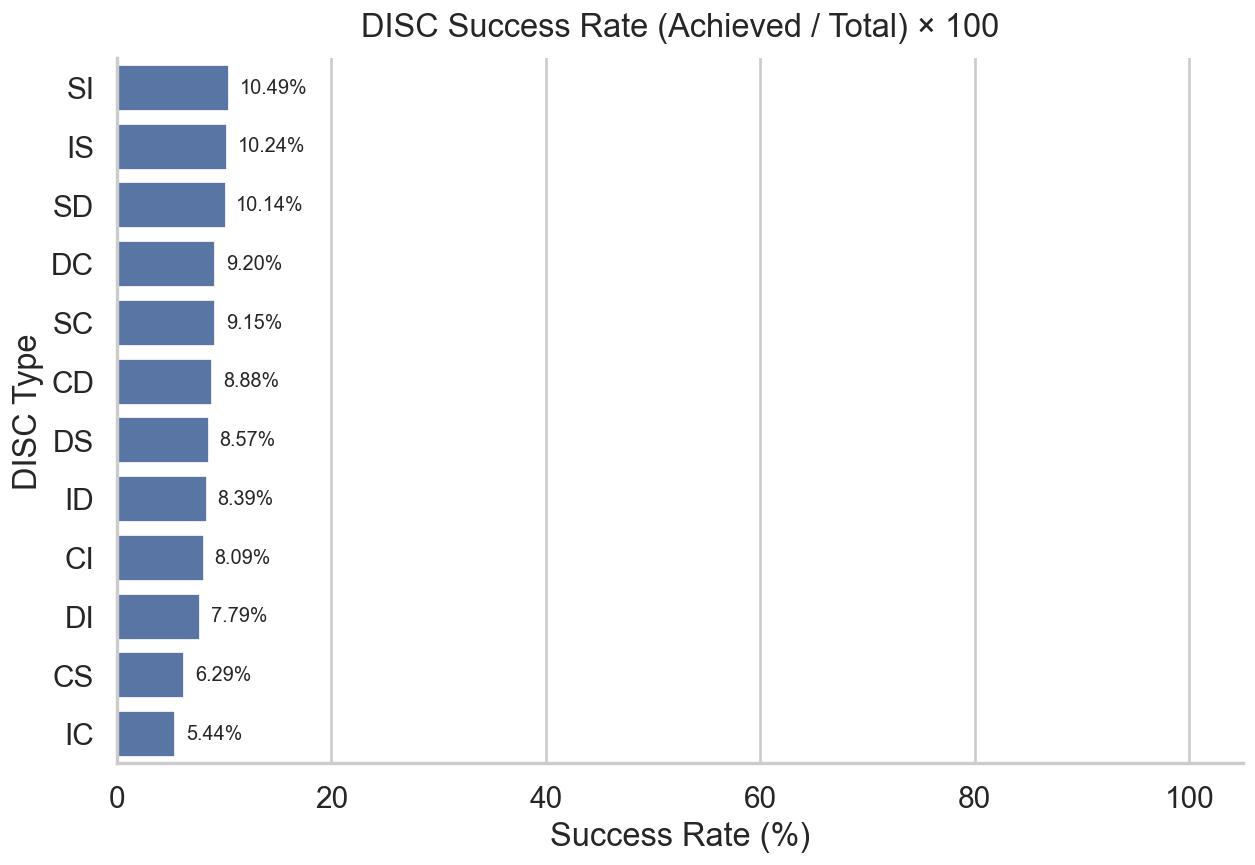

In [198]:
# Prepare data success rate per DISC
df_disc = df_psych_performance.copy()

# Uppercase handling & None
df_disc['disc'] = df_disc['disc'].astype(str).str.strip().str.upper()
df_disc = df_disc[~df_disc['disc'].isin(['', 'NONE'])]

# Flag consistency
df_disc['flag'] = df_disc['flag'].astype(str).str.strip().str.title()
df_disc['is_achieved'] = df_disc['flag'].eq('Achieved')

# Calculate success rate (Achieved / Total) * 100
rate = (
    df_disc.groupby('disc', as_index=False)
           .agg(achieved=('is_achieved', 'sum'),
                total=('is_achieved', 'size'))
)
rate['success_rate'] = (rate['achieved'] / rate['total'] * 100).round(2)
rate = rate.sort_values('success_rate', ascending=False)

# Plot barchart horizontal
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(10, 7), dpi=130)

sns.barplot(data=rate, y='disc', x='success_rate', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("DISC Success Rate (Achieved / Total) × 100", pad=12)
ax.set_xlabel("Success Rate (%)")
ax.set_ylabel("DISC Type")
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0, 105)  # 0–100 dengan headroom

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{w:.2f}%",
                (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()


#### Radar Charts on Psychometric Profiles

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\3864615893.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


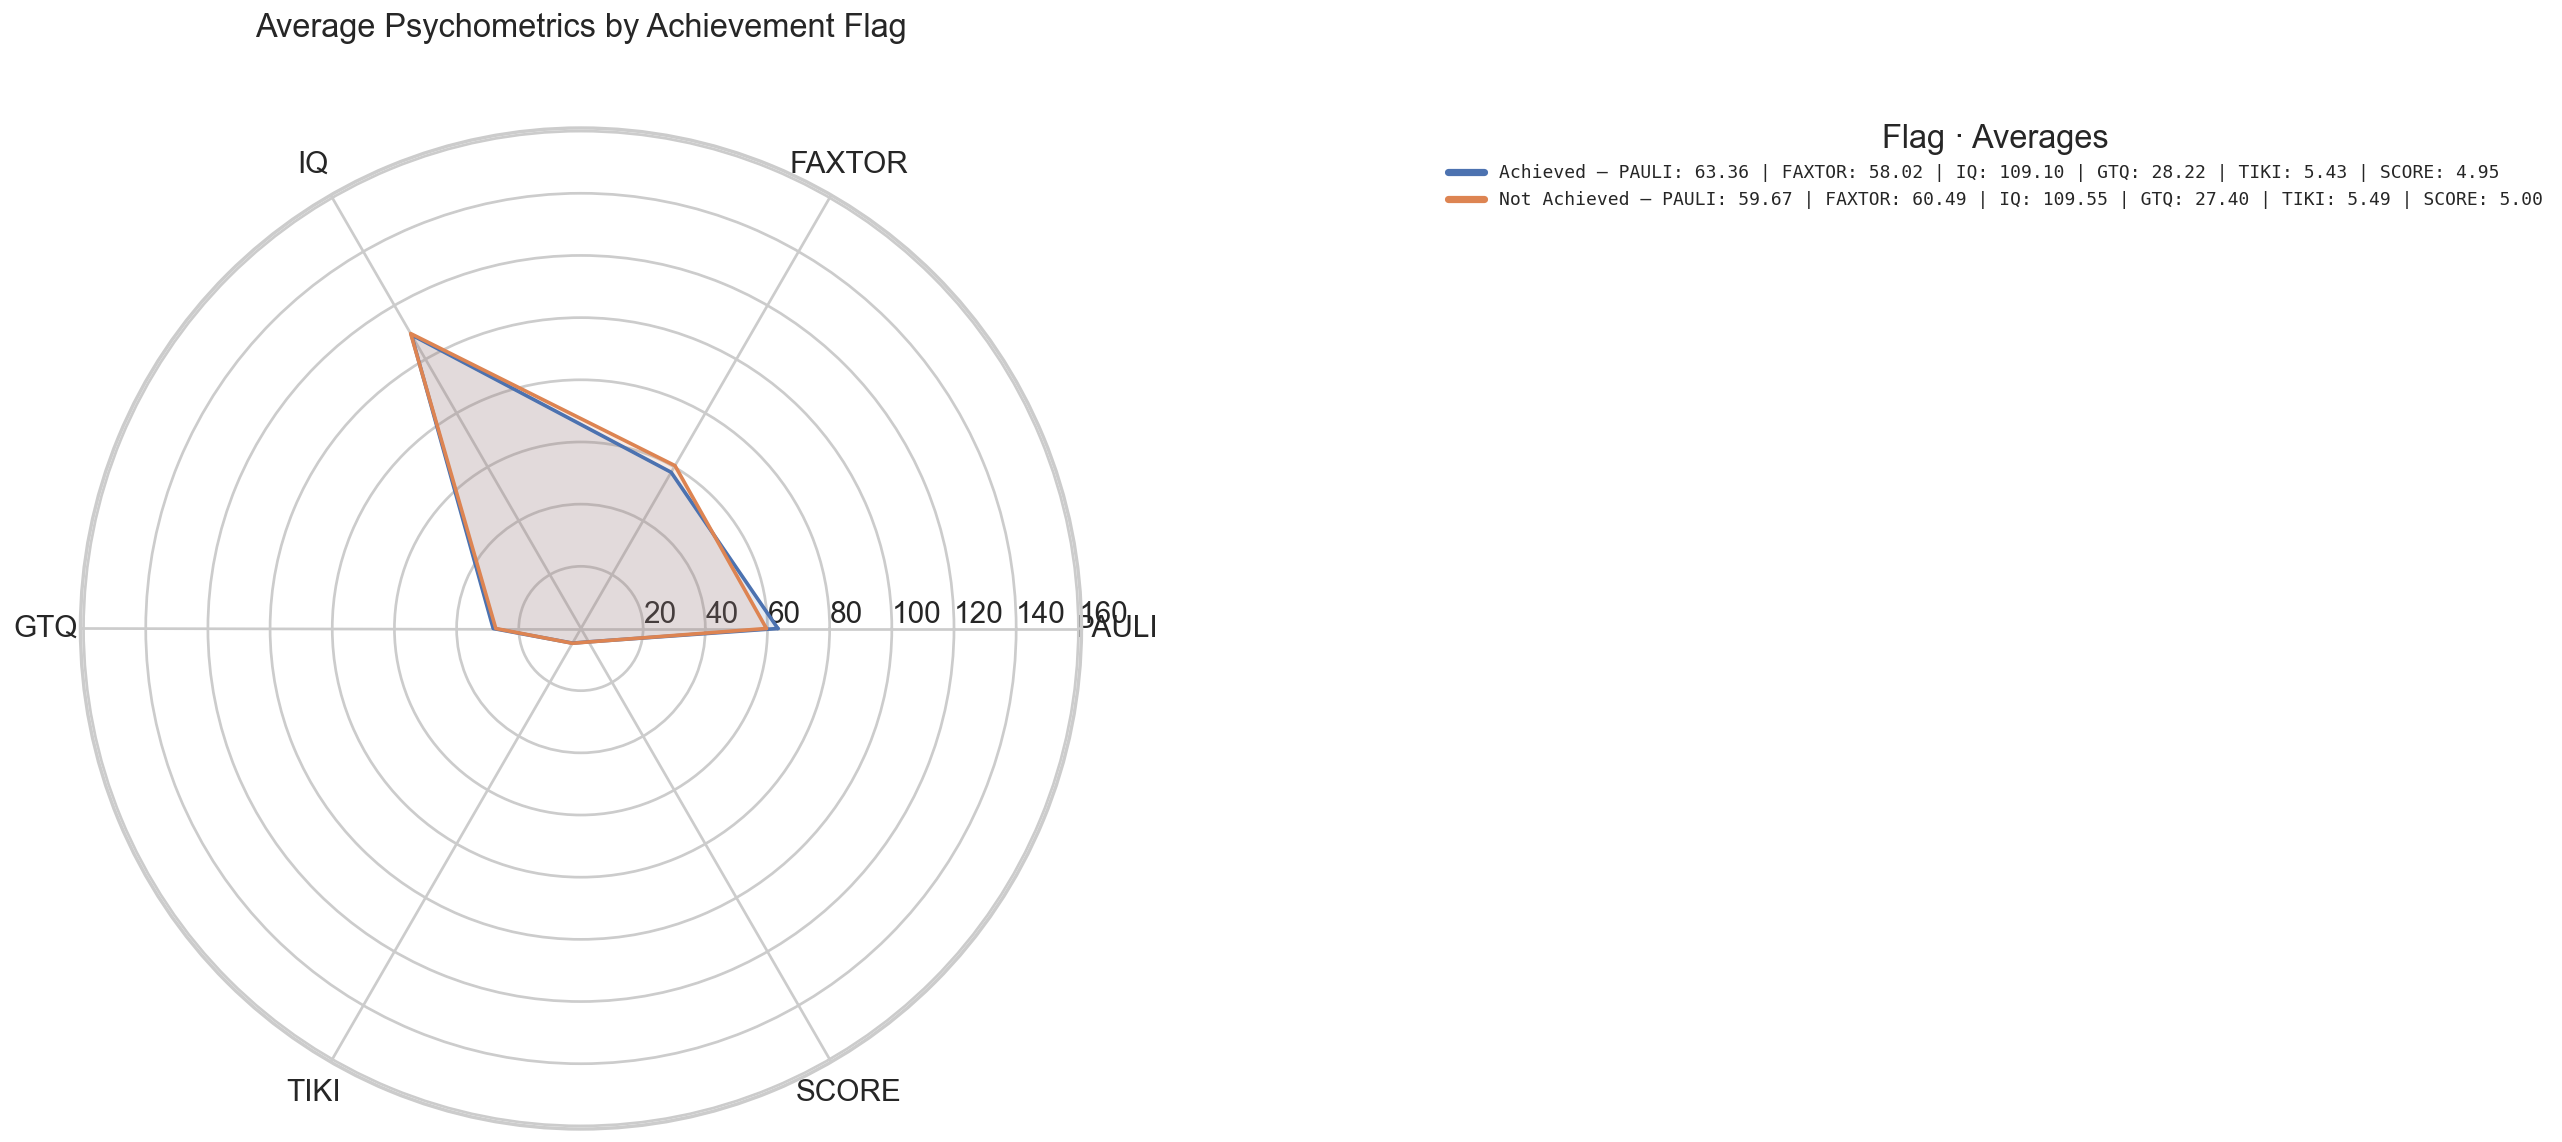

In [199]:
# Set plot theme
sns.set_theme(style="whitegrid", context="talk")

# Prepare data
metrics = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki', 'score']   # kolom numerik
df_radar = df_psych_performance.copy()
df_radar[metrics] = df_radar[metrics].apply(pd.to_numeric, errors='coerce')
df_radar['flag'] = df_radar['flag'].astype(str).str.strip().str.title()

mean_by_flag = df_radar.groupby('flag')[metrics].mean()

# Sort by legend
flag_order = [f for f in ['Achieved', 'Not Achieved'] if f in mean_by_flag.index]
mean_by_flag = mean_by_flag.loc[flag_order or mean_by_flag.index]

# Create radar chart
categories = metrics
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True), dpi=130)
palette = sns.color_palette(n_colors=len(mean_by_flag))

handles, labels = [], []

for (flag, row), color in zip(mean_by_flag.iterrows(), palette):
    values = row.values.tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, label=flag, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

    # siapkan legend text yang memuat angka
    legend_text = f"{flag} — " + " | ".join([f"{m.upper()}: {row[m]:.2f}" for m in metrics])
    handles.append(Line2D([0], [0], color=color, lw=4))
    labels.append(legend_text)

# Plot customization & styling
ax.set_xticks(angles[:-1])
ax.set_xticklabels([c.upper() for c in categories])
max_val = np.nanmax(df_radar[metrics].values)
ax.set_ylim(0, max_val * 1.15)
ax.set_rlabel_position(0)

ax.set_title("Average Psychometrics by Achievement Flag", y=1.08)

# Add data labels to legend
ax.legend(handles, labels, title="Flag · Averages",
          bbox_to_anchor=(1.35, 1.02), loc="upper left",
          frameon=False, prop={'family': 'monospace', 'size': 10})

# Show plot
plt.tight_layout()
plt.show()

### Behaviour Analysis

#### Data Merge

In [200]:
# Merge Behaviour Analysis with Performance
df_strengths_performance = df_strengths.merge(
    df_performance_latest, 
    how='left',
    on='employee_id')

df_strengths_performance.head()

,employee_id,rank,theme,rating,year,flag
0,EMP100000,1,,3.0,2025,Not Achieved
1,EMP100001,1,Responsibility,3.0,2025,Not Achieved
2,EMP100002,1,Restorative,4.0,2025,Not Achieved
3,EMP100003,1,Belief,3.0,2025,Not Achieved
4,EMP100004,1,Deliberative,4.0,2025,Not Achieved


#### Top Performance Strengths

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\1735121500.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rate, y='theme', x='success_rate', ci=None, ax=ax)


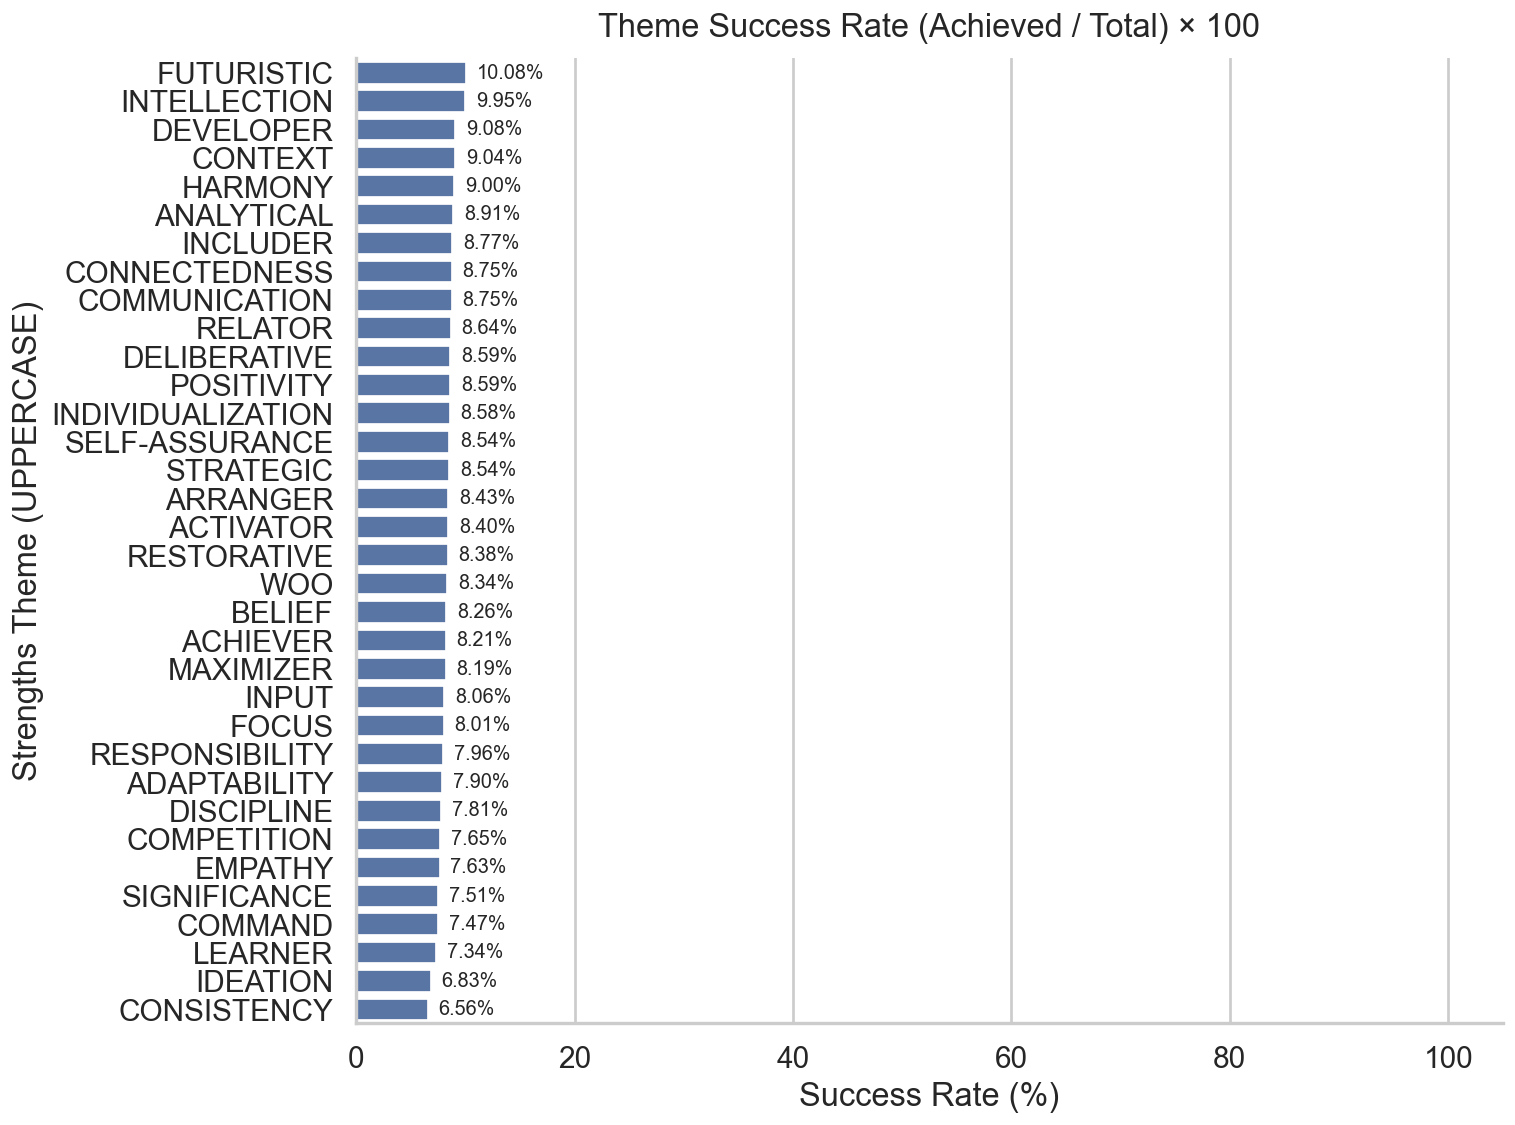

In [201]:
# Prepare data success rate per THEME (Strengths)
df_theme = df_strengths_performance.copy()

# Case normalization : THEME to UPPERCASE, FLAG to Title Case; handling None/empty values
df_theme['theme'] = df_theme['theme'].astype(str).str.strip().str.upper()
df_theme = df_theme[~df_theme['theme'].isin(['', 'NONE']) & df_theme['theme'].notna()]
df_theme['flag'] = df_theme['flag'].astype(str).str.strip().str.title()

# Flag Achieved
df_theme['is_achieved'] = df_theme['flag'].eq('Achieved')

# Calculate success rate per theme
rate = (
    df_theme.groupby('theme', as_index=False)
            .agg(achieved=('is_achieved', 'sum'),
                 total=('is_achieved', 'size'))
)
rate['success_rate'] = (rate['achieved'] / rate['total'] * 100).round(2)
rate = rate.sort_values('success_rate', ascending=False)

# Plot barchart horizontal
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 9), dpi=130)

sns.barplot(data=rate, y='theme', x='success_rate', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("Theme Success Rate (Achieved / Total) × 100", pad=12)
ax.set_xlabel("Success Rate (%)")
ax.set_ylabel("Strengths Theme (UPPERCASE)")
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0, 105)  # 0–100 + headroom

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{w:.2f}%",
                (w, y), xytext=(6, 0), textcoords='offset points',
                va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()


#### Top Strengths Performance

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\463446100.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, y='theme', x='count', ci=None, ax=ax)


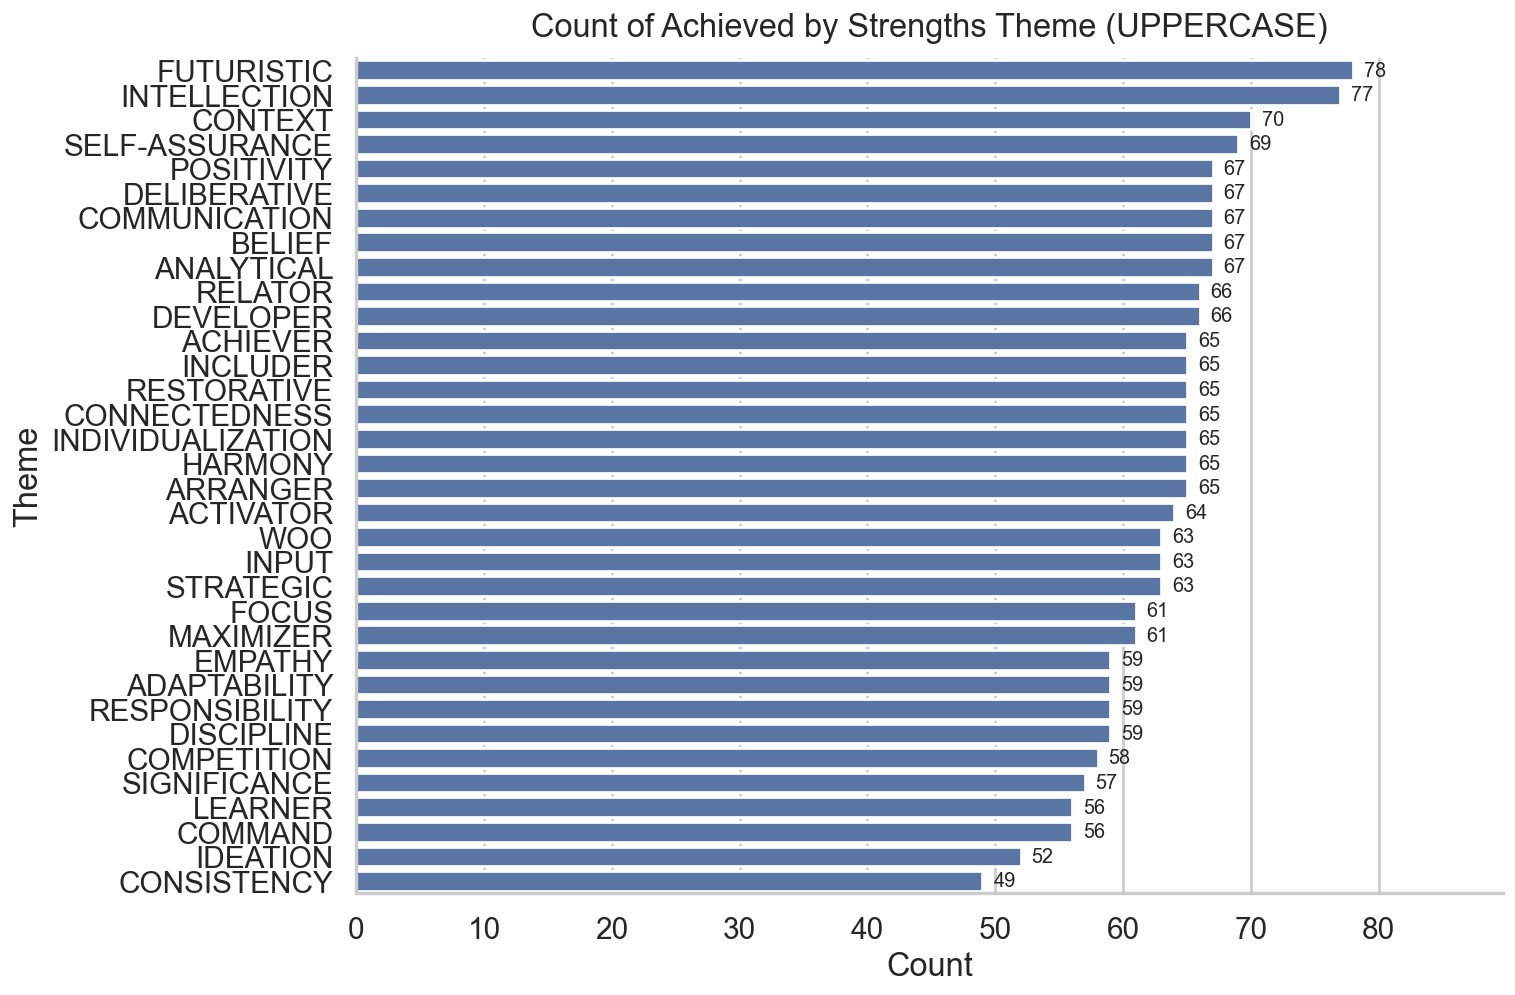

In [202]:
# Prepare data ---
df_ach = df_strengths_performance.copy()
df_ach['theme'] = df_ach['theme'].astype(str).str.strip().str.upper()
df_ach = df_ach[~df_ach['theme'].isin(['', 'NONE']) & df_ach['theme'].notna()]
df_ach['flag'] = df_ach['flag'].astype(str).str.strip().str.title()

# Calculate counts of strengths appear by flag
df_counts = (
    df_ach[df_ach['flag'] == 'Achieved']
    .groupby('theme', as_index=False)
    .size()
    .rename(columns={'size': 'count'})
    .sort_values('count', ascending=False)
)

# Plot barchart horizontal
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.barplot(data=df_counts, y='theme', x='count', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("Count of Achieved by Strengths Theme (UPPERCASE)", pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Theme")
ax.spines[['top', 'right']].set_visible(False)
if not df_counts.empty:
    ax.set_xlim(0, df_counts['count'].max() * 1.15)

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{int(w)}", (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()


### Contextual or Additional Factors

#### Data Merge

In [203]:
# Merge Additional Factors Analysis (Dimensions) with Performance
df_employees_performance = df_employees_dimension.merge(
    df_performance_latest[['employee_id', 'rating', 'flag']], 
    how='left',
    on='employee_id')

df_employees_performance.head()

,employee_id,fullname,nip,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name,rating,flag
0,EMP100000,Rendra Pratama,806137,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business,3.0,Not Achieved
1,EMP100001,Wulan Setiawan,476388,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design,3.0,Not Achieved
2,EMP100002,Julia Jatmiko Situmorang,941921,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business,4.0,Not Achieved
3,EMP100003,Oka Halim,751615,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology,3.0,Not Achieved
4,EMP100004,Dwi Pratama,443809,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology,4.0,Not Achieved


#### Years of Service Against Performance

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\3600587060.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_avg, x='flag', y='avg_years', ci=None, ax=ax)


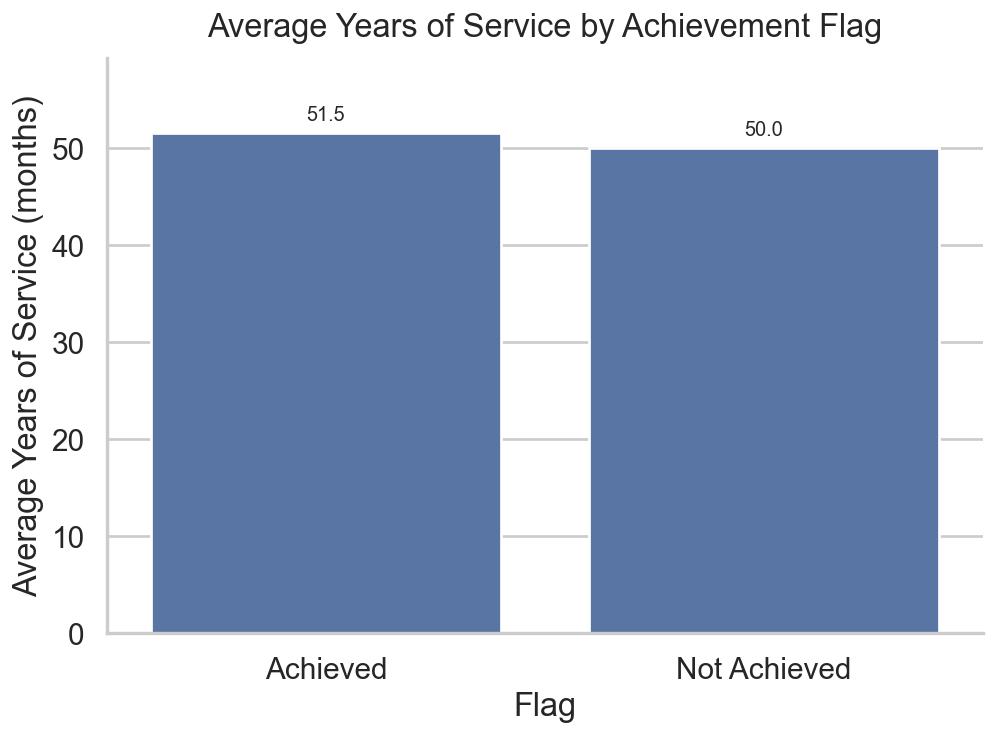

In [204]:
# Prepare data average years of service per flag ---
df_tmp = df_employees_performance.copy()
df_tmp['flag'] = df_tmp['flag'].astype(str).str.strip().str.title()  # samakan casing

df_avg = (
    df_tmp.dropna(subset=['years_of_service_months'])
          .groupby('flag', as_index=False)['years_of_service_months']
          .mean()
          .rename(columns={'years_of_service_months': 'avg_years'})
          .sort_values('avg_years', ascending=False)
)

# Plot barchart 
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 6), dpi=130)

sns.barplot(data=df_avg, x='flag', y='avg_years', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("Average Years of Service by Achievement Flag", pad=12)
ax.set_xlabel("Flag")
ax.set_ylabel("Average Years of Service (months)")
ax.spines[['top','right']].set_visible(False)
if not df_avg.empty:
    ax.set_ylim(0, df_avg['avg_years'].max() * 1.15)  # headroom untuk label

# Show data labels
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h:.1f}",
                (p.get_x() + p.get_width()/2, h),
                ha='center', va='bottom', fontsize=11,
                xytext=(0, 5), textcoords='offset points')

# Show plot
plt.tight_layout()
plt.show()

#### Education Effect on Performance Employees

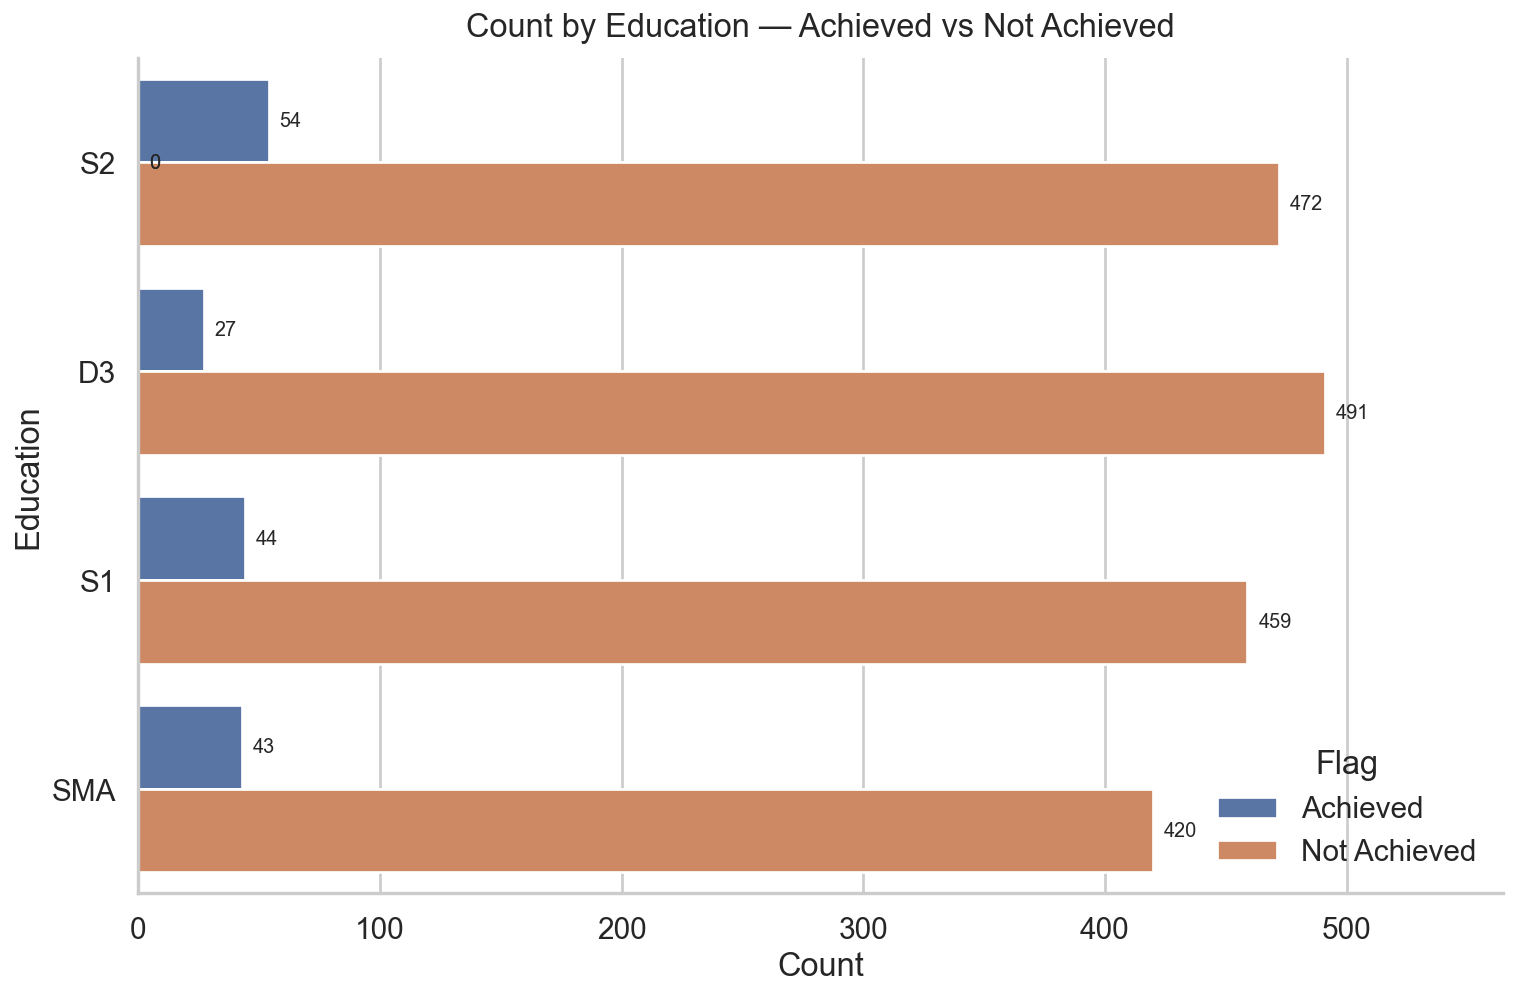

In [205]:
# Prepare data : Calculate counts of education_name per flag
df_ed = df_employees_performance.copy()
df_ed['education_name'] = df_ed['education_name'].astype(str).str.strip()
df_ed = df_ed[df_ed['education_name'].notna() & (df_ed['education_name'] != '') & (df_ed['education_name'].str.lower() != 'none')]
df_ed['flag'] = df_ed['flag'].astype(str).str.strip().str.title()  # Achieved / Not Achieved

counts = (
    df_ed.groupby(['education_name', 'flag'], dropna=False)
         .size().reset_index(name='count')
)

# Sort education based on highest count
order = (
    counts.groupby('education_name')['count']
          .sum()
          .sort_values(ascending=False)
          .index
)

# Plot horizontal bar with hue=flag
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.barplot(
    data=counts, y='education_name', x='count', hue='flag',
    order=order, ax=ax
)

# Plot customization & styling
ax.set_title("Count by Education — Achieved vs Not Achieved", pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Education")
ax.spines[['top','right']].set_visible(False)

# Show data labels
ax.set_xlim(0, counts['count'].max() * 1.15 if not counts.empty else 1)

for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{int(w)}", (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

ax.legend(title="Flag", frameon=False, loc='best')

# Show plot
plt.tight_layout()
plt.show()

#### Is Position Have Effect on Performance?

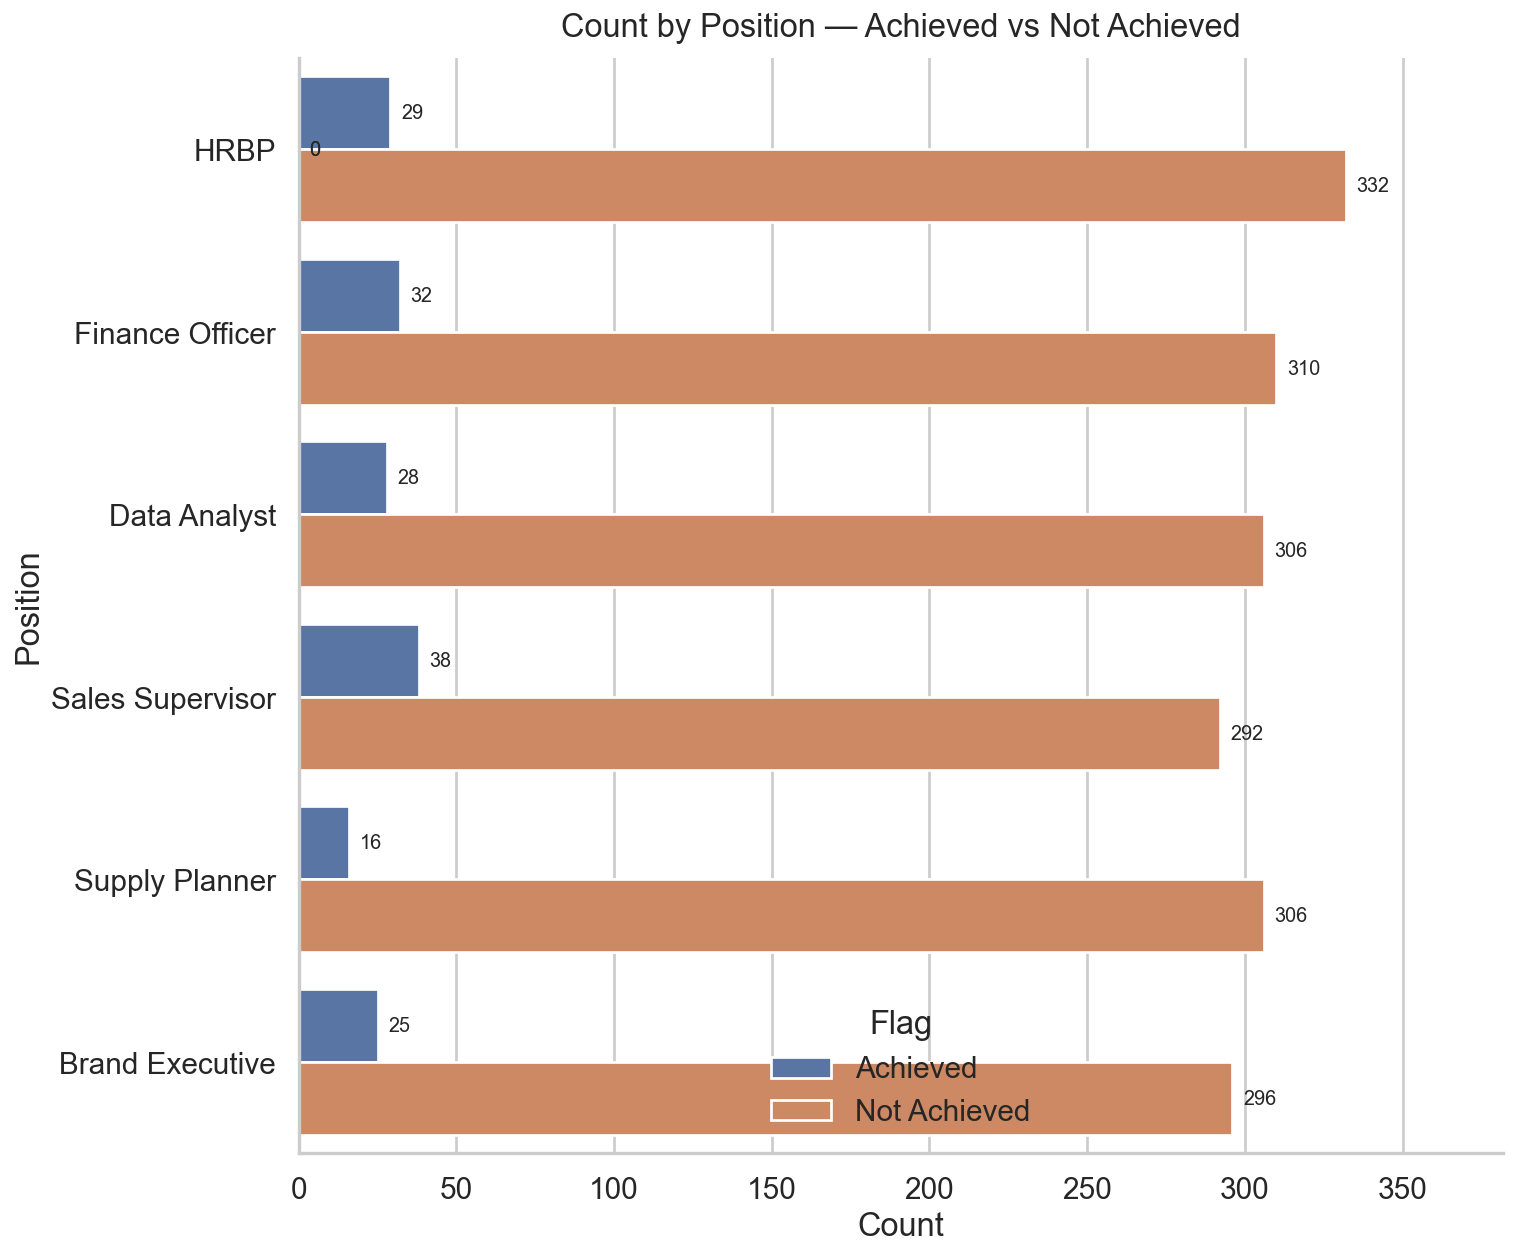

In [206]:
# Prepare data : Calculate counts position_name per flag
df_pos = df_employees_performance.copy()
df_pos['position_name'] = df_pos['position_name'].astype(str).str.strip()
df_pos = df_pos[
    df_pos['position_name'].notna()
    & (df_pos['position_name'] != '')
    & (df_pos['position_name'].str.lower() != 'none')
]
df_pos['flag'] = df_pos['flag'].astype(str).str.strip().str.title()  # Achieved / Not Achieved

counts = (
    df_pos.groupby(['position_name', 'flag'], dropna=False)
          .size().reset_index(name='count')
)

# Sort position based on highest counts
order = (
    counts.groupby('position_name')['count']
          .sum()
          .sort_values(ascending=False)
          .index
)

# Plot horizontal bar with hue=flag
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 10), dpi=130)

sns.barplot(
    data=counts, y='position_name', x='count', hue='flag',
    order=order, ax=ax
)

# Plot customization & styling
ax.set_title("Count by Position — Achieved vs Not Achieved", pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Position")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0, counts['count'].max() * 1.15 if not counts.empty else 1)

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{int(w)}", (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

ax.legend(title="Flag", frameon=False, loc='best')

# Show plot
plt.tight_layout()
plt.show()

#### Majors Effect on Performance Employees

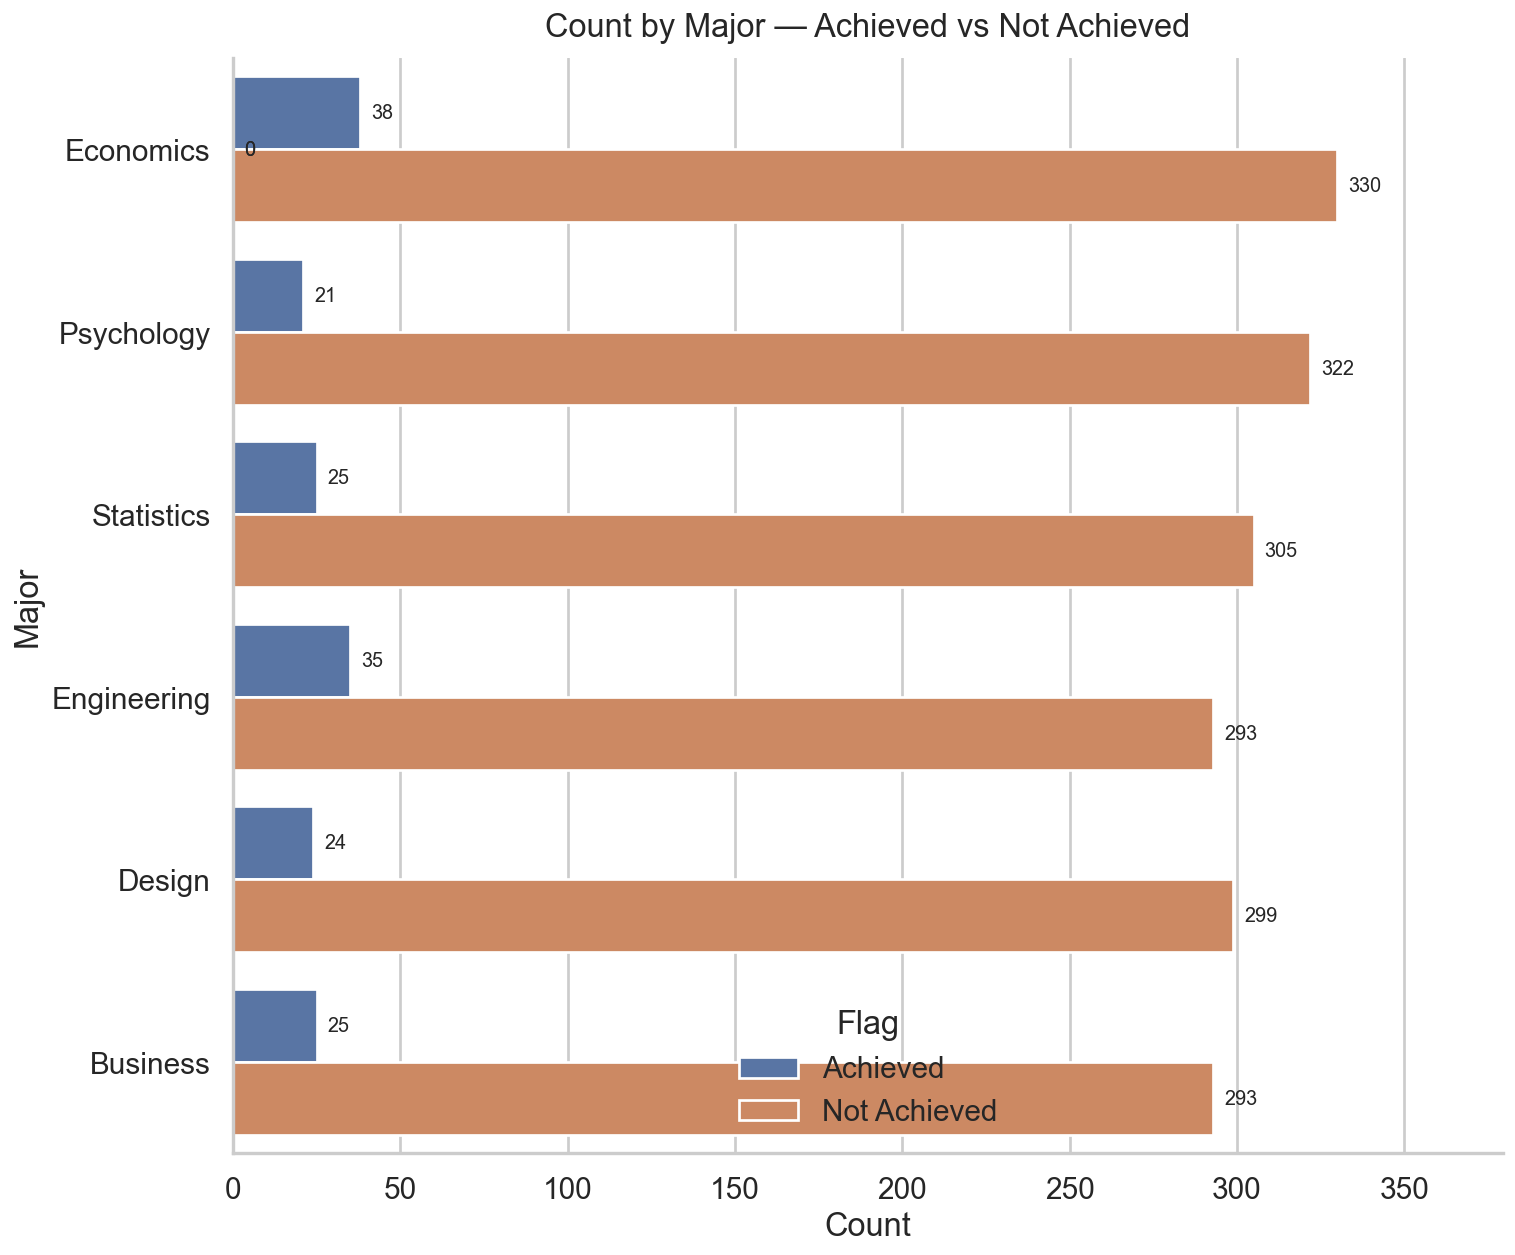

In [207]:
# Prepare data : Calculate counts major_name per flag ---
df_maj = df_employees_performance.copy()
df_maj['major_name'] = df_maj['major_name'].astype(str).str.strip()
df_maj = df_maj[
    df_maj['major_name'].notna()
    & (df_maj['major_name'] != '')
    & (df_maj['major_name'].str.lower() != 'none')
]
df_maj['flag'] = df_maj['flag'].astype(str).str.strip().str.title()  # Achieved / Not Achieved

counts = (
    df_maj.groupby(['major_name', 'flag'], dropna=False)
          .size().reset_index(name='count')
)

# Sort major based on highest counts
order = (
    counts.groupby('major_name')['count']
          .sum()
          .sort_values(ascending=False)
          .index
)

# Plot horizontal bar with hue=flag 
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 10), dpi=130)

sns.barplot(
    data=counts, y='major_name', x='count', hue='flag',
    order=order, ax=ax
)

# Plot customization & styling
ax.set_title("Count by Major — Achieved vs Not Achieved", pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Major")
ax.spines[['top','right']].set_visible(False)
ax.set_xlim(0, counts['count'].max() * 1.15 if not counts.empty else 1)

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{int(w)}", (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

ax.legend(title="Flag", frameon=False, loc='best')

# Show plot
plt.tight_layout()
plt.show()

#### Departments Achieved Rate

C:\Users\Orderfaz\AppData\Local\Temp\ipykernel_26352\591972519.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rate, y='department_name', x='achieved_rate', ci=None, ax=ax)


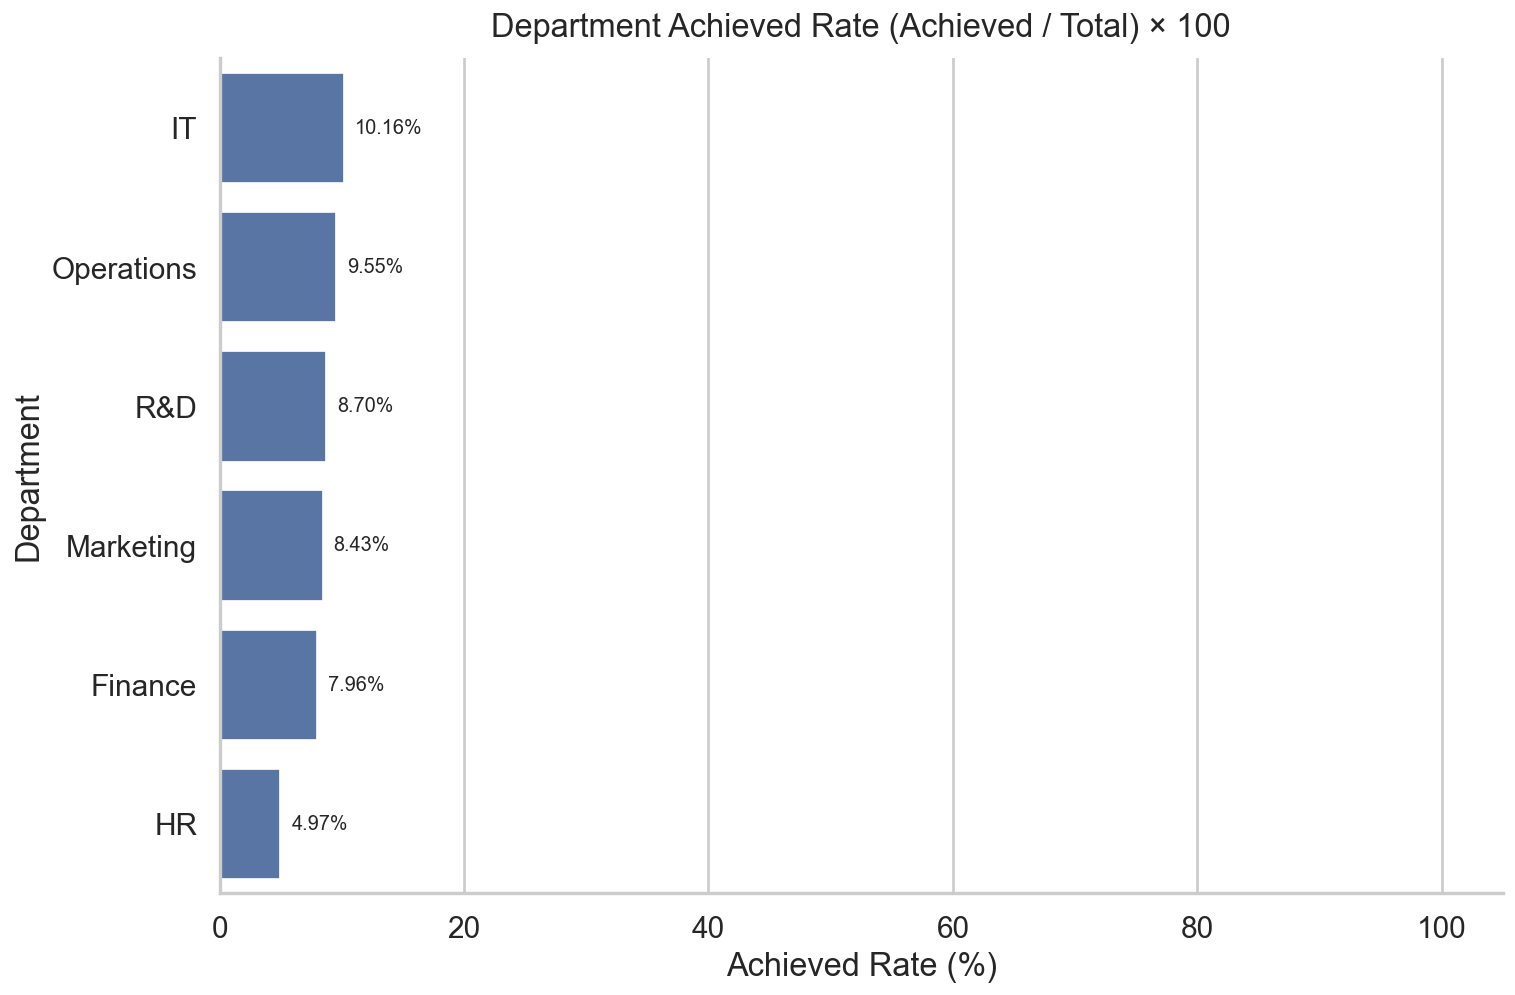

In [208]:
# Prepare data : Calculate Achieved Rate per department_name
df_dep = df_employees_performance.copy()

# Handling None/NaN/empty values
df_dep = df_dep[df_dep['department_name'].notna()]
df_dep['department_name'] = df_dep['department_name'].astype(str).str.strip()
df_dep = df_dep[
    (df_dep['department_name'] != '') &
    (df_dep['department_name'].str.lower() != 'none')
]

# Flag normalize then mark Achieved
df_dep['flag'] = df_dep['flag'].astype(str).str.strip().str.title()
df_dep['is_achieved'] = df_dep['flag'].eq('Achieved')

# Calculate Achieved Rate = Achieved / (Achieved + Not Achieved) * 100
rate = (
    df_dep.groupby('department_name', as_index=False)
          .agg(achieved=('is_achieved', 'sum'),
               total=('is_achieved', 'size'))
)
rate['achieved_rate'] = (rate['achieved'] / rate['total'] * 100).round(2)
rate = rate.sort_values('achieved_rate', ascending=False)

# Plot horizontal bar
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.barplot(data=rate, y='department_name', x='achieved_rate', ci=None, ax=ax)

# Plot customization & styling
ax.set_title("Department Achieved Rate (Achieved / Total) × 100", pad=12)
ax.set_xlabel("Achieved Rate (%)")
ax.set_ylabel("Department")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0, 105) 

# Show data labels
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.annotate(f"{w:.2f}%",
                (w, y), xytext=(6, 0),
                textcoords='offset points', va='center', ha='left', fontsize=11)

# Show plot
plt.tight_layout()
plt.show()

### Variable Justification

**Strong signals**

* **Competency Score (overall)**
  I see a large and consistent gap between Achieved and Not Achieved. The average score is clearly higher for Achieved, which makes Competency Score the single strongest discriminator. I can safely use a threshold or bucketed rule on this feature.
* **Education**
  The education chart shows higher Achieved counts at the S2 level relative to other levels with comparable base sizes. I treat education tier as a strong uplift that I can encode as rules such as S2 > S1, D3, SMA.

**Contextual signals**

* **MBTI**
  Success rates vary across types but the spread is modest. I will use MBTI as a secondary modifier inside competency bands rather than a primary split.
* **DISC**
  The success rate differences are small. I will treat DISC as a mild bonus or penalty that refines decisions after the main rules.
* **Theme (Strengths)**
  Success rates per theme cluster tightly. Counts are broadly even. I will use themes to enrich explanations or for role specific tweaks, not as gates.
* **Years of Service**
  The averages by flag are very close. Seniority on its own is not decisive. I will use tenure as a small modifier at most.
* **Major**
  Achieved appears across majors with similar proportions once I consider base sizes. I will keep major as a role specific nuance rather than a global rule.
* **Position**
  Achieved counts differ by role but base sizes differ too. I will use position to set role specific competency thresholds instead of a universal split.
* **Department**
  Achieved rates range roughly from five to ten percent across departments. I will apply department as a light weighting or tie breaker within broader rules.

**Weak or no signal**

* **Psychometrics Profile (Pauli, Faxtor, IQ, GTQ, TIKI)**
  Correlations with rating are near zero and radar overlays for the flags are almost identical. I will exclude these from first order rules.
* **PAPI Scores**
  I do not observe a meaningful relationship with the flag. I will leave them out of the rule base.
* **Competency Pillars (by pillar label)**
  Pillar level success rates are nearly identical. The aggregate competency score matters, but pillar mix does not separate outcomes. I will use pillars only for descriptive storytelling.


**Method choice for the rule based logic**

I will implement the simplest explainable approach, which is a small **Decision Tree** trained only on the **Strong** and **Contextual** variables. The tree is **easy to translate** into if-then rules, I can control complexity with a low max depth and minimum samples per leaf, and I can mitigate class imbalance using class weight balanced plus pruning. 

## Modelling Preparation

### Variable Selection

In [209]:
# Filter data employee
df_model = df_employees_dimension[['employee_id', 'years_of_service_months', 'education_name',
                                   'major_name', 'position_name', 'department_name']]

# Merge with psychometric profiles
df_model = df_model.merge(
    df_psych[['employee_id', 'disc', 'mbti']],
    how='left',
    on='employee_id'
)

# Merge with strengths 
# Choose only theme with highest rank per employee_id (highest rank with theme is not None/empty)
s = df_strengths.copy()
s['rank'] = pd.to_numeric(s['rank'], errors='coerce')
s['theme'] = s['theme'].astype(str).str.strip()
s['theme'] = s['theme'].replace({'None': np.nan, '': np.nan})

top_theme = (
    s.sort_values(['employee_id', 'rank'])   # sort by lowest rank
     .dropna(subset=['theme'])               # drop empty theme 
     .drop_duplicates('employee_id', keep='first')  # take theme with the highest rank per employee
     [['employee_id', 'theme']]
     .rename(columns={'theme': 'theme_top'})
)

# Left join to df_model
df_model = df_model.merge(top_theme[['employee_id', 'theme_top']], on='employee_id', how='left')
df_model

# Merge with competency score
df_model = df_model.merge(
    df_competencies_latest[['employee_id', 'score']],
    how='left',
    on='employee_id'
)

# Merge with performance
df_model = df_model.merge(
    df_performance_latest[['employee_id', 'flag']],
    how='left',
    on='employee_id'
)

df_model

,employee_id,years_of_service_months,education_name,major_name,position_name,department_name,disc,mbti,theme_top,score,flag
0,EMP100000,64,S2,Business,Brand Executive,R&D,SI,None,Adaptability,3.0,Not Achieved
1,EMP100001,16,D3,Design,HRBP,Operations,DS,INTP,Responsibility,3.0,Not Achieved
2,EMP100002,58,S2,Business,Sales Supervisor,Finance,DC,None,Restorative,3.0,Not Achieved
3,EMP100003,15,S1,Psychology,HRBP,HR,SI,ENTJ,Belief,3.0,Not Achieved
4,EMP100004,34,D3,Psychology,Supply Planner,Operations,None,INTJ,Deliberative,3.0,Not Achieved
...,...,...,...,...,...,...,...,...,...,...,...
2005,DUP1942,79,S1,Design,Brand Executive,Marketing,CD,ISFP,Learner,5.0,Achieved
2006,DUP2096,49,S2,Engineering,HRBP,Marketing,SD,ISFJ,Command,3.0,Not Achieved
2007,DUP4177,75,S1,Business,Supply Planner,Marketing,DS,ENTJ,Arranger,2.0,Not Achieved
2008,DUP9801,7,S1,Engineering,Finance Officer,IT,SC,ISTJ,Responsibility,5.0,Achieved


### Missing Values Handling

In [210]:
# Create empty list to store missing value information
lst_missval = []

# For loop to get each missing value information
for i in df_model.isnull().sum():
    # Calculate missing value percentage
    lst_missval.append((i / len(df_model) * 100))

# Create DataFrame to store columns name & missing value percentage
df_missval = pd.DataFrame({
    'Column Name': df_model.columns,
    'Missing Value Percentage (%)': np.round(lst_missval, 2)
})

# Sort DataFrame based on highest missing value percentage
df_missval.sort_values(by='Missing Value Percentage (%)',
                           ascending=False).reset_index().drop(columns='index')

,Column Name,Missing Value Percentage (%)
0,score,8.61
1,disc,8.51
2,mbti,7.41
3,education_name,0.00
4,years_of_service_months,0.00
5,employee_id,0.00
6,major_name,0.00
7,department_name,0.00
8,position_name,0.00
9,theme_top,0.00


In [211]:
# Fill missing value : Numeric --> Median ; Categoric --> Mode
df_model['score'] = df_model['score'].fillna(df_model['score'].median())
df_model['disc'] = df_model['disc'].fillna(df_model['disc'].mode()[0])
df_model['mbti'] = df_model['mbti'].fillna(df_model['mbti'].mode()[0])

### Label Encoding

In [212]:
# Copy dataframe
df_encode = df_model.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# List column names to encode
cols_to_encode = ['disc', 'mbti', 'theme_top', 'education_name',
                  'major_name', 'position_name', 'department_name']

# Dictionary to store value before & after mapping
encode_mapping = {}

# For loop list cols_to_encode
for col in cols_to_encode:
    # Store values before encode
    before = df_encode[col].unique().tolist()

    # Fit &* transform encoder
    df_encode[col] = le.fit_transform(df_encode[col])

    # Store mapping after encode
    after = le.classes_.tolist()
    mapping_dict = dict(zip(after, le.transform(after)))

    # Store values before & after mapping to dictionary
    encode_mapping[col] = {
        'before': before,
        'mapping': mapping_dict
    }

# Show data
df_encode.head()

,employee_id,years_of_service_months,education_name,major_name,position_name,department_name,disc,mbti,theme_top,score,flag
0,EMP100000,64,2,0,0,5,11,1,2,3.0,Not Achieved
1,EMP100001,16,0,1,3,4,5,11,28,3.0,Not Achieved
2,EMP100002,58,2,0,4,0,3,1,29,3.0,Not Achieved
3,EMP100003,15,1,4,3,1,11,2,5,3.0,Not Achieved
4,EMP100004,34,0,4,5,4,1,10,12,3.0,Not Achieved


### Define X & Y Variables

In [213]:
# Define predictor variables
X = df_encode.drop(columns=['employee_id', 'flag'])
# Define target variable
y = df_encode['flag'].values

### Split Dataset

In [214]:
# Split dataset to data train (80%) & data test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SMOTE

In [215]:
# SMOTE to handling imbalance
smote = SMOTE(random_state=42)
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)

## Modelling Decision Tree

### Model Training

In [216]:
# Define model Decision Tree
dt = DecisionTreeClassifier(
    max_depth=4,            # Set max_depth=4 to make tree easy & read-able 
    min_samples_leaf=50,    
    random_state=42
)

# Model training
dt.fit(X_train_sm, Y_train_sm)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Model Evaluation

In [217]:
# Evaluate on test set
y_pred = dt.predict(X_test)

# Calculate accuracy + macro-avg for each evaluation metrics 
acc  = accuracy_score(Y_test, y_pred)
prec = precision_score(Y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(Y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(Y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print(f"F1-score : {f1:.4f} (macro)\n")

# Create classification report
print(classification_report(Y_test, y_pred))

Accuracy : 0.9254
Precision: 0.7126 (macro)
Recall   : 0.8482 (macro)
F1-score : 0.7590 (macro)

              precision    recall  f1-score   support

    Achieved       0.44      0.76      0.56        25
Not Achieved       0.98      0.94      0.96       377

    accuracy                           0.93       402
   macro avg       0.71      0.85      0.76       402
weighted avg       0.95      0.93      0.93       402



### Tree Plot as Rule-Based Logic

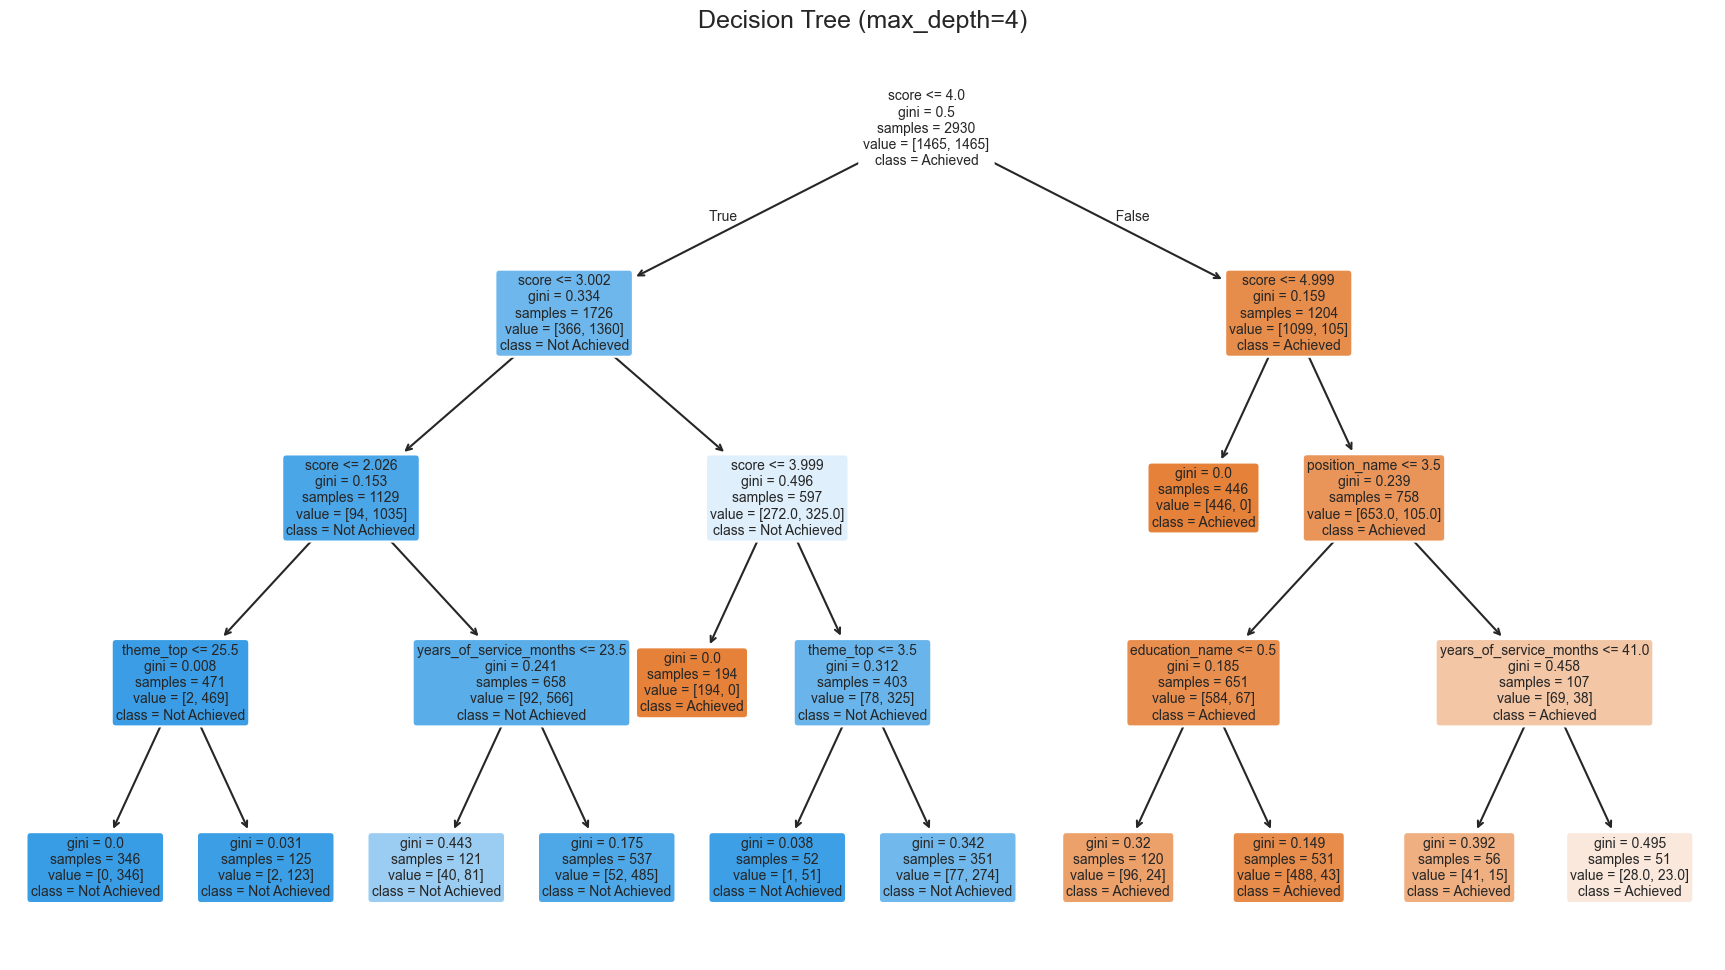

|--- score <= 4.00
|   |--- score <= 3.00
|   |   |--- score <= 2.03
|   |   |   |--- theme_top <= 25.50
|   |   |   |   |--- class: Not Achieved
|   |   |   |--- theme_top >  25.50
|   |   |   |   |--- class: Not Achieved
|   |   |--- score >  2.03
|   |   |   |--- years_of_service_months <= 23.50
|   |   |   |   |--- class: Not Achieved
|   |   |   |--- years_of_service_months >  23.50
|   |   |   |   |--- class: Not Achieved
|   |--- score >  3.00
|   |   |--- score <= 4.00
|   |   |   |--- class: Achieved
|   |   |--- score >  4.00
|   |   |   |--- theme_top <= 3.50
|   |   |   |   |--- class: Not Achieved
|   |   |   |--- theme_top >  3.50
|   |   |   |   |--- class: Not Achieved
|--- score >  4.00
|   |--- score <= 5.00
|   |   |--- class: Achieved
|   |--- score >  5.00
|   |   |--- position_name <= 3.50
|   |   |   |--- education_name <= 0.50
|   |   |   |   |--- class: Achieved
|   |   |   |--- education_name >  0.50
|   |   |   |   |--- class: Achieved
|   |   |--- position_n

In [218]:
# Create Tree plot
plt.figure(figsize=(22, 12))
plot_tree(
    dt,
    feature_names=X.columns,                # gunakan nama fitur asli
    class_names=[str(c) for c in np.unique(y)],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (max_depth=4)")
plt.show()

# Show tree plot as text
print(export_text(dt, feature_names=list(X.columns)))

### Invert Mapping on Tree Rule-Based Logic

In [219]:
# Build inverse maps: code -> original label for each encoded column
encoded_cols = ['disc', 'mbti', 'theme_top', 'education_name',
                'major_name', 'position_name', 'department_name']

inv_maps = {}
for c in encoded_cols:
    code_by_label = encode_mapping[c]['mapping']     # label -> code
    inv_maps[c] = {int(v): str(k) for k, v in code_by_label.items()}  # code -> label

# helper to convert a numeric threshold into sets of category labels
def split_labels_for_threshold(col, thr, inv_map):
    """
    For label-encoded column 'col' and threshold 'thr' like 3.5,
    return the left-set (<= thr) and right-set (> thr) of original labels.
    """
    codes = sorted(inv_map[col].keys())
    cut = int(np.floor(thr))  # e.g., 3.5 -> 3
    left_codes  = [k for k in codes if k <= cut]
    right_codes = [k for k in codes if k >  cut]
    left_labels  = [inv_map[col][k] for k in left_codes]
    right_labels = [inv_map[col][k] for k in right_codes]
    return left_labels, right_labels

# pretty print IF-THEN rules with original labels for encoded columns
def print_readable_rules(model, feature_names, class_names, inv_maps):
    tree = model.tree_

    def recurse(node, path):
        feat_idx = tree.feature[node]
        if feat_idx != _tree.TREE_UNDEFINED:
            feat_name = feature_names[feat_idx]
            thr = tree.threshold[node]

            # LEFT branch (<= thr)
            if feat_name in inv_maps:
                left_labels, _ = split_labels_for_threshold(feat_name, thr, inv_maps)
                cond_left = f"{feat_name} in {{{', '.join(left_labels)}}}"
            else:
                cond_left = f"{feat_name} <= {thr:.3f}"
            recurse(tree.children_left[node], path + [cond_left])

            # RIGHT branch (> thr)
            if feat_name in inv_maps:
                _, right_labels = split_labels_for_threshold(feat_name, thr, inv_maps)
                cond_right = f"{feat_name} in {{{', '.join(right_labels)}}}"
            else:
                cond_right = f"{feat_name} > {thr:.3f}"
            recurse(tree.children_right[node], path + [cond_right])

        else:
            counts = tree.value[node][0]
            pred = class_names[np.argmax(counts)]
            print(f"IF {' AND '.join(path)} THEN class = {pred} "
                  f"(samples={int(tree.n_node_samples[node])}, "
                  f"dist={counts.astype(int).tolist()})")

    recurse(0, [])

# Call function
print_readable_rules(dt, feature_names=list(X.columns),
                     class_names=dt.classes_, inv_maps=inv_maps)

IF score <= 4.000 AND score <= 3.002 AND score <= 2.026 AND theme_top in {Achiever, Activator, Adaptability, Analytical, Arranger, Belief, Command, Communication, Competition, Connectedness, Consistency, Context, Deliberative, Developer, Discipline, Empathy, Focus, Futuristic, Harmony, Ideation, Includer, Individualization, Input, Intellection, Learner, Maximizer} THEN class = Not Achieved (samples=346, dist=[0, 1])
IF score <= 4.000 AND score <= 3.002 AND score <= 2.026 AND theme_top in {Positivity, Relator, Responsibility, Restorative, Self-Assurance, Significance, Strategic, Woo} THEN class = Not Achieved (samples=125, dist=[0, 0])
IF score <= 4.000 AND score <= 3.002 AND score > 2.026 AND years_of_service_months <= 23.500 THEN class = Not Achieved (samples=121, dist=[0, 0])
IF score <= 4.000 AND score <= 3.002 AND score > 2.026 AND years_of_service_months > 23.500 THEN class = Not Achieved (samples=537, dist=[0, 0])
IF score <= 4.000 AND score > 3.002 AND score <= 3.999 THEN class 

## Final Conclusions

**What differentiates rating-5 performers**

* **Competency Score is the decisive separator.**
  When the overall competency score is low (≤3.0), the tree consistently predicts **Not Achieved**. When the score is high (>4.0), virtually all paths end in **Achieved**. This aligns with the large mean gap I observed in the bar chart.
* **Education provides uplift but is secondary to competency.**
  S2 shows higher Achieved counts in EDA. In the tree, education appears only on high-score branches, never reversing an Achieved decision. I treat education as confidence-boosting once competency is already strong or borderline.
* **Behavioral traits act as contextual refiners.**
  Strengths themes appear in a narrow boundary around a score of exactly ~4.0. A small subset of themes showed lower odds at that exact boundary, but the effect is small and sample-sensitive. I will treat themes as a tiebreaker only.
* **Job context matters modestly.**
  Position and tenure appear in high-score branches but do not change the Achieved outcome. Department effects are visible in EDA (≈5–10% range) yet remain weaker than competency.
* **Psychometrics and pillar mix add little separation.**
  IQ/Pauli/Faxtor/GTQ/TIKI and PAPI show near-zero correlations, and pillar-level success rates are almost identical. I keep them for narrative, not for rules.

**My rule-based Success Formula**

I will operationalize the findings as a compact set of if-then rules that mirror the trained Decision Tree:

1. **If `competency_score` ≤ 3.0 → predict Not Achieved.**
   This covers the entire low-score region regardless of theme, tenure, or context.
2. **If 3.0 < `competency_score` < 4.0 → predict Achieved.**
   This band is generally positive in the model. If I want a conservative variant at the exact 4.0 boundary, I can down-weight a few themes that showed slightly lower odds, but the support is small so I keep the default as Achieved.
3. **If `competency_score` ≥ 4.0 → predict Achieved.**
   Outcome remains Achieved across positions, tenure splits, and education branches.
4. **Confidence adjustments (do not flip outcomes by themselves):**

   * **+** Higher education (S2).
   * **±** Minor nudges for MBTI, DISC, and Strengths only when the score is near thresholds.
   * **±** Small department or position adjustments as role-specific nuance.

These rules answer the core “why”:

* High competency is the principal driver of rating-5.
* Education strengthens the case but rarely overrides competency.
* Behavioral and organizational context refine confidence around the threshold, not the decision itself.

**Modeling choice and traceability**

* I used a **small Decision Tree** trained on Strong plus Contextual variables (after class balance with SMOTE). The tree yields auditable rules that match the logic above and are easy to implement in production and to explain to stakeholders.
* I will keep class-imbalance checks and minimum-support constraints when promoting any fine-grained theme or department tweak, so I avoid overfitting to small pockets.

**Rule-based model performance**

* **Headline metrics on the held-out test set**

  * Accuracy: **0.9254**
  * Macro Precision: **0.7126**
  * Macro Recall: **0.8482**
  * Macro F1: **0.7590**
* **Per class view**

  * Achieved: precision **0.44**, recall **0.76**, F1 **0.56** (support 25)
  * Not Achieved: precision **0.98**, recall **0.94**, F1 **0.96** (support 377)
* **Interpretation**

  * Overall accuracy is high, driven by the dominant Not Achieved class.
  * I recover most high performers (Achieved recall 0.76), which is consistent with the tree focusing on competency score thresholds.
  * Precision for Achieved is lower (0.44). This means some employees predicted as Achieved still fall short. In other words, the rules are inclusive around the Achieved boundary and trade precision for recall.
* **What this means for use**

  * If the business prefers catching as many potential rating-5 employees as possible, this configuration is acceptable because recall for Achieved is solid.
  * If the business prefers fewer false positives for Achieved, I can tighten the rules by raising the competency threshold near 4.0, simplifying the tree depth, or adding a cost-sensitive setting.
